# Set up environment

In [4]:
import torch
# Check CUDA version is >= 12.1
cuda_version = torch.version.cuda
if cuda_version is None:
    print("CUDA not available")
else:
    major, minor = map(int, cuda_version.split('.')[:2])
    if major < 12 or (major == 12 and minor < 1):
        raise RuntimeError(f"CUDA version {cuda_version} detected. Version 12.1 or later is required due to known bugs with torch.fft.fft in earlier versions.")
    else:
        print(f"CUDA version {cuda_version} detected - OK")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA version 12.1 detected - OK


In [5]:
#%% import libraries
import os
from collections import defaultdict
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import numpy as np
import numpy.random
from numpy.fft import fft as fft
from numpy.fft import ifft as ifft
import pickle
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import KFold
from sklearn.manifold import TSNE
import scipy.stats
from scipy.stats import wilcoxon, chi2
import scipy.interpolate 
import scipy.signal
from scipy import linalg
from scipy.special import rel_entr
from tqdm import tqdm
import pandas as pd
import joblib
import logging

import statsmodels.api as sm
import statsmodels.genmod.generalized_linear_model as smm

import torch
from torch.autograd import Variable
from torch.nn import functional as F
import torch.nn as nn
import torch.optim as optim

In [7]:
# import my code
import utility_functions as utils
import GLM
from DataLoader import Allen_dataset, Allen_dataloader_multi_session, Simple_dataloader_from_spikes
from model_trainer import Trainer

# Set random seed
utils.set_seed(0)

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Generate synthetic data

In [7]:
######### Settings #########
external_input_params = {
    "external_input_type": "two_peaks_with_all_varying",
    "std1": 10,
    "corr1": 0.5,
    "std2": 25,
    "corr2": 0.5,
    "use_two_modes": False,
    "gp_time_constant": 300,
    "gp_amplitude": 0.1,
}

conn = 0.1
nneuron_coupling = 10
nneuron = 100
nneuron_part = nneuron//2
npadding = 50
############################

spikes, trial_info, I_ext, I_syn = GLM.EIF_simulator(
    ntrial=2000,
    nneuron=nneuron,
    conn=conn,
    nneuron_coupling=nneuron_coupling,
    params=external_input_params, 
    return_trial_info=True,
    return_I_ext=True,
    return_I_syn=True,
)

print(f"Size of spikes array in MB: {spikes.nbytes / (1024 * 1024):.2f} MB")


100%|██████████| 2000/2000 [02:50<00:00, 11.74it/s]

Size of spikes array in MB: 457.76 MB


In [8]:
# Save data to local file using numpy's save function
np.savez_compressed(f'/home/qix/user_data/EIF_simulation_dataset/synthetic_data_EIF_conn{str(conn!=0)}.npz',
                    spikes=spikes,
                    trial_info=trial_info,
                    I_ext=I_ext,
                    I_syn=I_syn)



In [139]:
load_data_name = '/home/qix/user_data/EIF_simulation_dataset/synthetic_data_EIF_connTrue.npz'
# load_data_name = '/home/qix/user_data/EIF_simulation_dataset/synthetic_data_EIF_connFalse.npz'

data = np.load(load_data_name, allow_pickle=True)
spikes = data['spikes']
trial_info = data['trial_info']
I_ext = data['I_ext']
I_syn = data['I_syn']



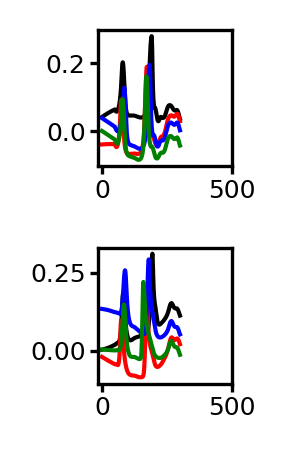

In [140]:
# plt.plot(current[:,0,0:5])

# plot only currents
utils.use_pdf_plot()
color_list = ['k', 'r', 'b', 'g']


plt.subplots(2, 1, figsize=(1.0, 1.6), dpi=300)
# plt.subplots(figsize=(6.2, 6.7))

plt.subplot(2,1,1)
for i, color in enumerate(color_list):
    plt.plot(0.1*np.arange(I_ext.shape[0]), I_ext[:,:nneuron_part,i].mean(axis=1), color=color)
plt.xticks([0, 500])
# plt.yticks([])

plt.subplot(2,1,2)
for i, color in enumerate(color_list):
    plt.plot(0.1*np.arange(I_ext.shape[0]), I_ext[:,nneuron_part:,i].mean(axis=1), color=color)
plt.xticks([0, 500])
# plt.yticks([])

plt.tight_layout()

# plt.savefig('Figures/Synthetic Dataset/(lower) currents.pdf', format='pdf', dpi=300)
plt.show()

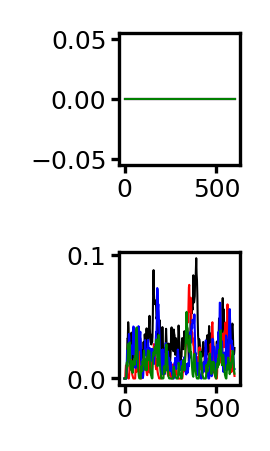

In [144]:
# plt.plot(current[:,0,0:5])

# plot only currents
utils.use_pdf_plot()
color_list = ['k', 'r', 'b', 'g']


plt.subplots(2, 1, figsize=(1.0, 1.6), dpi=300)
# plt.subplots(figsize=(6.2, 6.7))

plt.subplot(2,1,1)
for i, color in enumerate(color_list):
    plt.plot(2*np.arange(I_syn.shape[0]), 
             I_syn[:,:nneuron_part,i].mean(axis=1), 
             color=color,
             lw=0.5)
plt.xticks([0, 500])
# plt.yticks([])

plt.subplot(2,1,2)
for i, color in enumerate(color_list):
    plt.plot(2*np.arange(I_syn.shape[0]), 
             I_syn[:,nneuron_part:nneuron_part+nneuron_coupling,i].mean(axis=1), 
             color=color,
             lw=0.5)
plt.xticks([0, 500])
# plt.yticks([])

plt.tight_layout()

# plt.savefig('Figures/Synthetic Dataset/(lower) currents.pdf', format='pdf', dpi=300)
plt.show()

Text(0.5, 1.0, 'Spike raster for neuron 50')

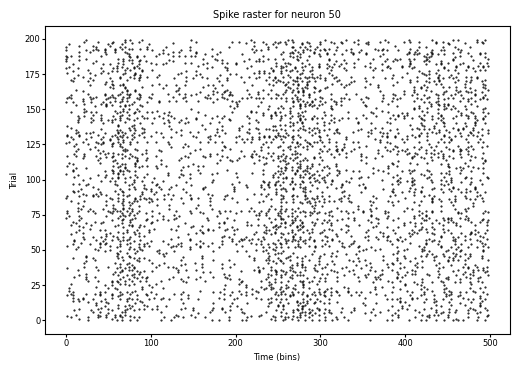

In [142]:
# Plot raster for one example neuron
neuron_idx = nneuron_part  # Choose first neuron
plt.figure(figsize=(6,4))
for trial in range(200):  # Plot first 200 trials
    spike_times = np.where(spikes[npadding:,neuron_idx,trial])[0]*2
    plt.plot(spike_times, trial*np.ones_like(spike_times), '.', markersize=1, color='black')
plt.xlabel('Time (bins)')
plt.ylabel('Trial')
plt.title(f'Spike raster for neuron {neuron_idx}')


In [143]:
synthetic_dataloader = Simple_dataloader_from_spikes(
    [spikes[:,:nneuron_part,:], spikes[:,nneuron_part:,:]],
    npadding=50,
    train_ratio=0.7,
    val_ratio=0.1,
    batch_size=64,
    verbose=True
)

# Train a model

Current problems:
- Not stable! Run the code multiple times, the results are different. **Solved by temporal correlation penalty**
- The coupling effect is not capturing what it should capture. ** **

Things I want to try:
- see if the baseline looks good. **YES**
- I want to get a clear two modes in t-sne plot, since the ground truth is two modes. **YES**
- Play with hyperparameters, see what appect the results. **lr is still very important. Epoch is also important.**
- Try make coupling effect weaker by setting initial value to be around zero. I don't want to see the coupling effect being too strong. **can be done by frozing Transformer encoder**
- See how would overlapping penalty affect the results. overlapping_penalty=None: 0.2283
overlapping_penalty=1e0: 0.2289. **but overlapping penalty makes coupling very small**
- Try penalty temporal correlation. **Works great!**
- Try not frozing Transformer encoder. **(a different dataset than the previous one) 0.2300 vs 0.2308. So Yes, frozing encoder**
- Try cls token. **No, will lead to mode collapse**
- Get a set of hyperparameters that works in both conn=0.0 and conn=0.01. ** **
- compare with no f(z,t) but just f(t). The coupling effect should be much stronger. 


- I don't know why the first element in both sending and receiving weights are much larger than the rest.


In [152]:
FIT_THE_BASELINE_MODEL = False

# data_to_use = cross_session_dataloader
data_to_use = synthetic_dataloader
ckp_path = '/home/qix/user_data/VAETransformer_checkpoint_ipynb'

params = {
    # B-spline basis
    'num_B_spline_basis': 20,
    # Transformer VAE's settings
    'downsample_factor': 10,
    'transformer_num_layers': 2,
    'transformer_d_model': 128,
    'transformer_dim_feedforward': 512,
    'transformer_vae_output_dim': 16,
    'transformer_dropout': 0.0,
    'transformer_nhead': 1,
    'stimulus_nfactor': 1,
    'stimulus_decoder_inter_dim_factor': 2,
    'beta': 1.0,
    'use_area_specific_decoder': True,
    'use_area_specific_encoder': True,
    'use_cls': False,
    # Coupling's settings
    'coupling_basis_peaks_max': 5,
    'coupling_basis_num': 3,
    'coupling_nsubspace': 1,
    'use_self_coupling': True,
    # Coupling strength latent's settings
    'K_sigma2': 1.0,
    'K_tau': 100,
    'coupling_strength_nlatent': 1,
    # Penalty settings
    'penalty_smoothing_spline': 1e2,
    'penalty_effect_overlapping': None, 
    'penalty_coupling_subgroup': 1e-5,
    'penalty_diff_loading': None,
    # Training settings
    'batch_size': 64,
    'sample_latent': False,
    'lr': 1e-3,
    'epoch_warm_up': 0,
    'epoch_patience': 3,
    'epoch_max': 200,
    'tol': 1e-5,
    'weight_decay': 0,
    'lr_transformer': 1e-4,
    'lr_sti': 1e-2,
    'lr_cp': 1e-2,
}

trainer = Trainer(data_to_use, ckp_path, params)

if FIT_THE_BASELINE_MODEL:
    # Baseline model: no trial-varying stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )

else:
    # First step: train the model with a trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=True,
        fix_latents=True,
        verbose=True,
    )
    # Second step: train the model with a trial-varying stimulus effect
    # trainer.make_optimizer(frozen_params=['sti_readout'])
    trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
    trainer.train(
        include_stimulus=True,
        include_coupling=False,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )

    trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
    # trainer.make_optimizer(frozen_params=[])
    trainer.train(
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=False,
        fix_latents=True,
        verbose=True,
    )



/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1e-05, 'weight_decay': 0, 'lr_transformer': 0.0001, 'lr_sti': 0.01, 'lr_cp': 0.01}


100%|██████████| 4/4 [00:00<00:00, 276.67it/s]


Epoch 1/200, Train Loss: 1.0338, Test Loss: 0.8715


100%|██████████| 4/4 [00:00<00:00, 243.42it/s]


Epoch 2/200, Train Loss: 0.7254, Test Loss: 0.5716


100%|██████████| 4/4 [00:00<00:00, 267.06it/s]


Epoch 3/200, Train Loss: 0.4668, Test Loss: 0.3705


100%|██████████| 4/4 [00:00<00:00, 249.81it/s]


Epoch 4/200, Train Loss: 0.3238, Test Loss: 0.2829


100%|██████████| 4/4 [00:00<00:00, 297.77it/s]


Epoch 5/200, Train Loss: 0.2682, Test Loss: 0.2519


100%|██████████| 4/4 [00:00<00:00, 265.99it/s]


Epoch 6/200, Train Loss: 0.2484, Test Loss: 0.2402


100%|██████████| 4/4 [00:00<00:00, 288.78it/s]


Epoch 7/200, Train Loss: 0.2403, Test Loss: 0.2349


100%|██████████| 4/4 [00:00<00:00, 280.41it/s]


Epoch 8/200, Train Loss: 0.2365, Test Loss: 0.2322


100%|██████████| 4/4 [00:00<00:00, 287.65it/s]


Epoch 9/200, Train Loss: 0.2345, Test Loss: 0.2308


100%|██████████| 4/4 [00:00<00:00, 288.05it/s]


Epoch 10/200, Train Loss: 0.2334, Test Loss: 0.2299


100%|██████████| 4/4 [00:00<00:00, 172.15it/s]


Epoch 11/200, Train Loss: 0.2327, Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 296.82it/s]


Epoch 12/200, Train Loss: 0.2323, Test Loss: 0.2291


100%|██████████| 4/4 [00:00<00:00, 210.10it/s]


Epoch 13/200, Train Loss: 0.2321, Test Loss: 0.2289


100%|██████████| 4/4 [00:00<00:00, 269.55it/s]


Epoch 14/200, Train Loss: 0.2320, Test Loss: 0.2288


100%|██████████| 4/4 [00:00<00:00, 272.44it/s]


Epoch 15/200, Train Loss: 0.2319, Test Loss: 0.2287


100%|██████████| 4/4 [00:00<00:00, 178.58it/s]


Epoch 16/200, Train Loss: 0.2318, Test Loss: 0.2287


100%|██████████| 4/4 [00:00<00:00, 258.39it/s]


Epoch 17/200, Train Loss: 0.2318, Test Loss: 0.2286


100%|██████████| 4/4 [00:00<00:00, 198.93it/s]


Epoch 18/200, Train Loss: 0.2317, Test Loss: 0.2286


100%|██████████| 4/4 [00:00<00:00, 290.84it/s]


Epoch 19/200, Train Loss: 0.2317, Test Loss: 0.2286


100%|██████████| 4/4 [00:00<00:00, 298.28it/s]


Epoch 20/200, Train Loss: 0.2317, Test Loss: 0.2286


100%|██████████| 4/4 [00:00<00:00, 287.88it/s]


Epoch 21/200, Train Loss: 0.2317, Test Loss: 0.2286
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2286


100%|██████████| 4/4 [00:00<00:00, 183.92it/s]


Epoch 22/200, Train Loss: 0.2317, Test Loss: 0.2286


100%|██████████| 4/4 [00:00<00:00, 282.82it/s]


Epoch 23/200, Train Loss: 0.2317, Test Loss: 0.2285
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2286


100%|██████████| 4/4 [00:00<00:00, 289.22it/s]


Epoch 24/200, Train Loss: 0.2317, Test Loss: 0.2285
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2286


100%|██████████| 4/4 [00:00<00:00, 300.25it/s]


Epoch 25/200, Train Loss: 0.2317, Test Loss: 0.2285


100%|██████████| 4/4 [00:00<00:00, 244.53it/s]


Epoch 26/200, Train Loss: 0.2317, Test Loss: 0.2285
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2285


100%|██████████| 4/4 [00:00<00:00, 280.91it/s]


Epoch 27/200, Train Loss: 0.2317, Test Loss: 0.2285
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2285


100%|██████████| 4/4 [00:00<00:00, 298.61it/s]
/home/qix/FC-GPFA/model_trainer.py:256: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(te

Epoch 28/200, Train Loss: 0.2317, Test Loss: 0.2285
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2285
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max

100%|██████████| 4/4 [00:00<00:00, 219.25it/s]


Epoch 1/200, Train Loss: 0.2367, Test Loss: 0.2281


100%|██████████| 4/4 [00:00<00:00, 217.94it/s]


Epoch 2/200, Train Loss: 0.2303, Test Loss: 0.2268


100%|██████████| 4/4 [00:00<00:00, 218.34it/s]


Epoch 3/200, Train Loss: 0.2299, Test Loss: 0.2267


100%|██████████| 4/4 [00:00<00:00, 217.52it/s]


Epoch 4/200, Train Loss: 0.2297, Test Loss: 0.2266


100%|██████████| 4/4 [00:00<00:00, 218.16it/s]


Epoch 5/200, Train Loss: 0.2296, Test Loss: 0.2265


100%|██████████| 4/4 [00:00<00:00, 220.71it/s]


Epoch 6/200, Train Loss: 0.2295, Test Loss: 0.2264


100%|██████████| 4/4 [00:00<00:00, 225.60it/s]


Epoch 7/200, Train Loss: 0.2294, Test Loss: 0.2263


100%|██████████| 4/4 [00:00<00:00, 216.87it/s]


Epoch 8/200, Train Loss: 0.2293, Test Loss: 0.2261


100%|██████████| 4/4 [00:00<00:00, 193.31it/s]


Epoch 9/200, Train Loss: 0.2292, Test Loss: 0.2260


100%|██████████| 4/4 [00:00<00:00, 210.41it/s]


Epoch 10/200, Train Loss: 0.2290, Test Loss: 0.2260
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2260


100%|██████████| 4/4 [00:00<00:00, 209.22it/s]


Epoch 11/200, Train Loss: 0.2289, Test Loss: 0.2257


100%|██████████| 4/4 [00:00<00:00, 222.09it/s]


Epoch 12/200, Train Loss: 0.2287, Test Loss: 0.2255


100%|██████████| 4/4 [00:00<00:00, 183.96it/s]


Epoch 13/200, Train Loss: 0.2285, Test Loss: 0.2253


100%|██████████| 4/4 [00:00<00:00, 225.12it/s]


Epoch 14/200, Train Loss: 0.2283, Test Loss: 0.2251


100%|██████████| 4/4 [00:00<00:00, 197.66it/s]


Epoch 15/200, Train Loss: 0.2282, Test Loss: 0.2250


100%|██████████| 4/4 [00:00<00:00, 186.56it/s]


Epoch 16/200, Train Loss: 0.2280, Test Loss: 0.2250


100%|██████████| 4/4 [00:00<00:00, 192.32it/s]


Epoch 17/200, Train Loss: 0.2279, Test Loss: 0.2248


100%|██████████| 4/4 [00:00<00:00, 217.66it/s]


Epoch 18/200, Train Loss: 0.2278, Test Loss: 0.2247


100%|██████████| 4/4 [00:00<00:00, 214.70it/s]


Epoch 19/200, Train Loss: 0.2277, Test Loss: 0.2247
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2247


100%|██████████| 4/4 [00:00<00:00, 214.41it/s]


Epoch 20/200, Train Loss: 0.2276, Test Loss: 0.2245


100%|██████████| 4/4 [00:00<00:00, 214.44it/s]


Epoch 21/200, Train Loss: 0.2276, Test Loss: 0.2245


100%|██████████| 4/4 [00:00<00:00, 224.89it/s]


Epoch 22/200, Train Loss: 0.2275, Test Loss: 0.2245


100%|██████████| 4/4 [00:00<00:00, 220.88it/s]


Epoch 23/200, Train Loss: 0.2275, Test Loss: 0.2244


100%|██████████| 4/4 [00:00<00:00, 202.17it/s]


Epoch 24/200, Train Loss: 0.2274, Test Loss: 0.2244


100%|██████████| 4/4 [00:00<00:00, 220.23it/s]


Epoch 25/200, Train Loss: 0.2274, Test Loss: 0.2244
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2244


100%|██████████| 4/4 [00:00<00:00, 221.83it/s]


Epoch 26/200, Train Loss: 0.2274, Test Loss: 0.2244


100%|██████████| 4/4 [00:00<00:00, 223.51it/s]


Epoch 27/200, Train Loss: 0.2273, Test Loss: 0.2242


100%|██████████| 4/4 [00:00<00:00, 213.61it/s]


Epoch 28/200, Train Loss: 0.2273, Test Loss: 0.2242


100%|██████████| 4/4 [00:00<00:00, 214.76it/s]


Epoch 29/200, Train Loss: 0.2272, Test Loss: 0.2242


100%|██████████| 4/4 [00:00<00:00, 214.24it/s]


Epoch 30/200, Train Loss: 0.2272, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 215.98it/s]


Epoch 31/200, Train Loss: 0.2272, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 226.22it/s]


Epoch 32/200, Train Loss: 0.2272, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 215.85it/s]


Epoch 33/200, Train Loss: 0.2271, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 223.59it/s]


Epoch 34/200, Train Loss: 0.2271, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 212.46it/s]


Epoch 35/200, Train Loss: 0.2271, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 218.06it/s]


Epoch 36/200, Train Loss: 0.2271, Test Loss: 0.2241
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 216.94it/s]


Epoch 37/200, Train Loss: 0.2271, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 227.78it/s]


Epoch 38/200, Train Loss: 0.2271, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 234.32it/s]


Epoch 39/200, Train Loss: 0.2271, Test Loss: 0.2240
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 232.94it/s]


Epoch 40/200, Train Loss: 0.2271, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 164.52it/s]


Epoch 41/200, Train Loss: 0.2270, Test Loss: 0.2240
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 220.98it/s]


Epoch 42/200, Train Loss: 0.2270, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 165.40it/s]


Epoch 43/200, Train Loss: 0.2270, Test Loss: 0.2240
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 212.33it/s]


Epoch 44/200, Train Loss: 0.2270, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 217.40it/s]


Epoch 45/200, Train Loss: 0.2270, Test Loss: 0.2240
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 212.82it/s]


Epoch 46/200, Train Loss: 0.2270, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 206.94it/s]


Epoch 47/200, Train Loss: 0.2270, Test Loss: 0.2240
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 221.77it/s]


Epoch 48/200, Train Loss: 0.2270, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 220.81it/s]


Epoch 49/200, Train Loss: 0.2270, Test Loss: 0.2239
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 217.18it/s]


Epoch 50/200, Train Loss: 0.2270, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 221.92it/s]


Epoch 51/200, Train Loss: 0.2270, Test Loss: 0.2239
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 217.24it/s]


Epoch 52/200, Train Loss: 0.2270, Test Loss: 0.2239
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 218.86it/s]


Epoch 53/200, Train Loss: 0.2269, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 214.01it/s]


Epoch 54/200, Train Loss: 0.2269, Test Loss: 0.2239
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 218.18it/s]


Epoch 55/200, Train Loss: 0.2269, Test Loss: 0.2239
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 222.37it/s]


Epoch 56/200, Train Loss: 0.2269, Test Loss: 0.2239
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2239
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'penalty_smoothing_spline': 100.0, 'penalty_effect_overlapping': None, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max

100%|██████████| 4/4 [00:00<00:00, 186.82it/s]


Epoch 1/200, Train Loss: 0.2270, Test Loss: 0.2238


100%|██████████| 4/4 [00:00<00:00, 142.92it/s]


Epoch 2/200, Train Loss: 0.2267, Test Loss: 0.2236


100%|██████████| 4/4 [00:00<00:00, 175.13it/s]


Epoch 3/200, Train Loss: 0.2266, Test Loss: 0.2235


100%|██████████| 4/4 [00:00<00:00, 185.77it/s]


Epoch 4/200, Train Loss: 0.2265, Test Loss: 0.2235


100%|██████████| 4/4 [00:00<00:00, 126.15it/s]


Epoch 5/200, Train Loss: 0.2265, Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 178.48it/s]


Epoch 6/200, Train Loss: 0.2265, Test Loss: 0.2234
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 142.01it/s]


Epoch 7/200, Train Loss: 0.2265, Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 96.04it/s]


Epoch 8/200, Train Loss: 0.2265, Test Loss: 0.2234
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 173.07it/s]


Epoch 9/200, Train Loss: 0.2265, Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 179.64it/s]


Epoch 10/200, Train Loss: 0.2264, Test Loss: 0.2234
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 140.77it/s]


Epoch 11/200, Train Loss: 0.2264, Test Loss: 0.2234
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 158.49it/s]

Epoch 12/200, Train Loss: 0.2264, Test Loss: 0.2234
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2234
Early stopping triggered.


In [153]:
# Compare the model's prediction with a baseline model
### Which dataset to use?
loader = trainer.dataloader.test_loader

###
trainer.model.normalize_coupling_coefficients()
trainer.model.eval()
trainer.model.sample_latent = False
test_loss = 0.0
test_loss_baseline = 0.0
total_trial = 0
test_loss_record = []
with torch.no_grad():
    for i, batch in enumerate(tqdm(loader)):
        trainer.process_batch(batch)
        firing_rate = trainer.model(
            batch,
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
        )
        loss = trainer.model.loss_function(
            firing_rate, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_record.append(loss.item())
        test_loss += loss.item() * batch["spike_trains"].size(2)
        total_trial += batch["spike_trains"].size(2)
        if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
            firing_rate_baseline = (
                torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                    * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
            )
        
        loss_baseline = trainer.model.loss_function(
            firing_rate_baseline, 
            batch["spike_trains"][trainer.npadding:,:,:], 
            trainer.model.sti_mu, 
            trainer.model.sti_logvar, 
            beta=trainer.params['beta']
        )
        test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

test_loss /= total_trial
test_loss_baseline /= total_trial
print(f"Test loss: {test_loss}")
print(f"Test loss baseline: {test_loss_baseline}")

100%|██████████| 7/7 [00:00<00:00, 183.12it/s]

Test loss: 0.2275670187505998
Test loss baseline: 0.23623750286357956


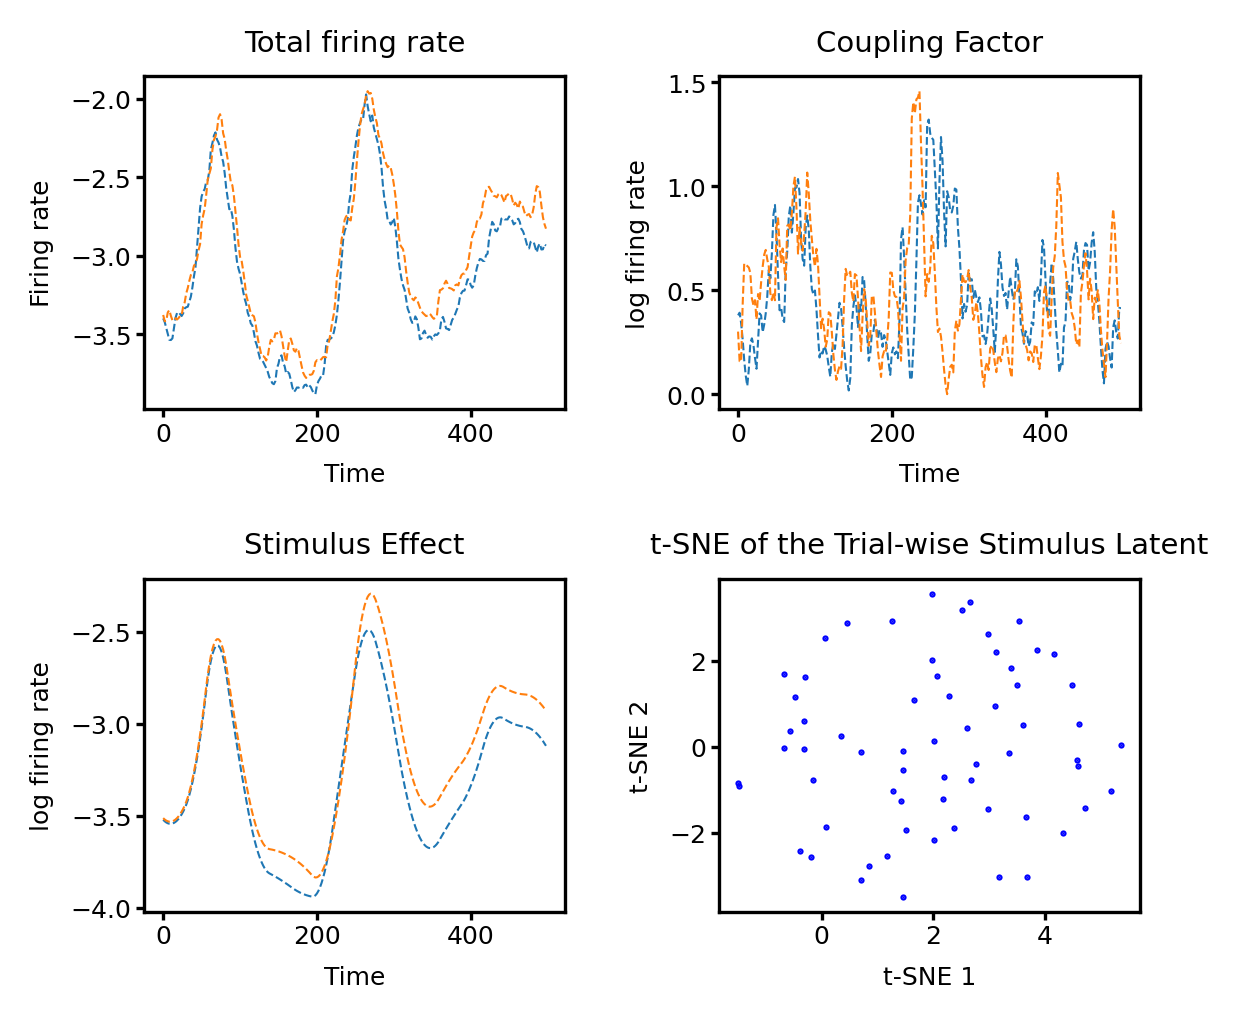

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from sklearn.manifold import TSNE

local_trial_indices = np.arange(0, 2)
neuron_idx = nneuron_part

firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices, spike_train_test = trainer.predict(
    dataset='test',
    batch_indices=[0],
    include_stimulus=True,
    include_coupling=True,
    fix_stimulus=False,
    fix_latents=True,
    return_torch=True,
    return_trial_indices=True,
    return_spike_trains=True,
)

# Create a 2x2 subplot figure
utils.use_pdf_plot()
fig, axes = plt.subplots(2, 2, figsize=(4, 3.5), dpi=300)

# Plot total firing rate
xx = np.arange(firing_rate_test.shape[0]) * 2  # Adjusted x-axis
for trial_idx in local_trial_indices:
    # Plot predicted
    axes[0, 0].plot(
        xx,
        firing_rate_test[:, neuron_idx, trial_idx].cpu().numpy(),
        linestyle='--',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'fitted',
        lw=0.5,
    )
axes[0, 0].set_title('Total firing rate')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Firing rate')

# Plot coupling factor
for trial_idx in local_trial_indices:
    # Plot predicted
    axes[0, 1].plot(
        xx,
        trainer.model.coupling_outputs_subspace[0][1][trial_idx, 0, :].cpu().numpy(),
        linestyle='--',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'fitted',
        lw=0.5,
    )

axes[0, 1].set_title('Coupling Factor')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('log firing rate')

# Plot stimulus effect
for trial_idx in local_trial_indices:
    # Plot predicted
    axes[1, 0].plot(
        xx,
        trainer.model.firing_rates_stimulus[trial_idx, neuron_idx, :].cpu().numpy(),
        linestyle='--',
        color=f'C{trial_idx}',  # Use matplotlib default color cycle
        label=f'fitted',
        lw=0.5,
    )
    

axes[1, 0].set_title('Stimulus Effect')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('log firing rate')


# Plot t-SNE in the last subplot
sti_mu_test_np = sti_mu_test.cpu().numpy() if torch.is_tensor(sti_mu_test) else sti_mu_test

if sti_mu_test_np.shape[1] <= 2:
    print(f"Only one dimension")
elif np.all(sti_mu_test_np.std(axis=0) > 1e-3):
    tsne = TSNE(n_components=2, random_state=42)
    sti_mu_test_tsne = tsne.fit_transform(sti_mu_test_np)
    for i in range(len(sti_mu_test_tsne)):
        axes[1, 1].scatter(
            sti_mu_test_tsne[i, 0],
            sti_mu_test_tsne[i, 1],
            marker='.',
            s=1,
            color='b'
        )
    axes[1, 1].set_title('t-SNE of the Trial-wise Stimulus Latent')
    axes[1, 1].set_xlabel('t-SNE 1')
    axes[1, 1].set_ylabel('t-SNE 2')
else:
    print(
        f"Stimulus latent is not varying across trials: "
        f"{sti_mu_test_np.std(axis=0).mean()}"
    )

plt.tight_layout()
# plt.savefig('Figure/all_effects_and_tsne.pdf', bbox_inches='tight', dpi=300)


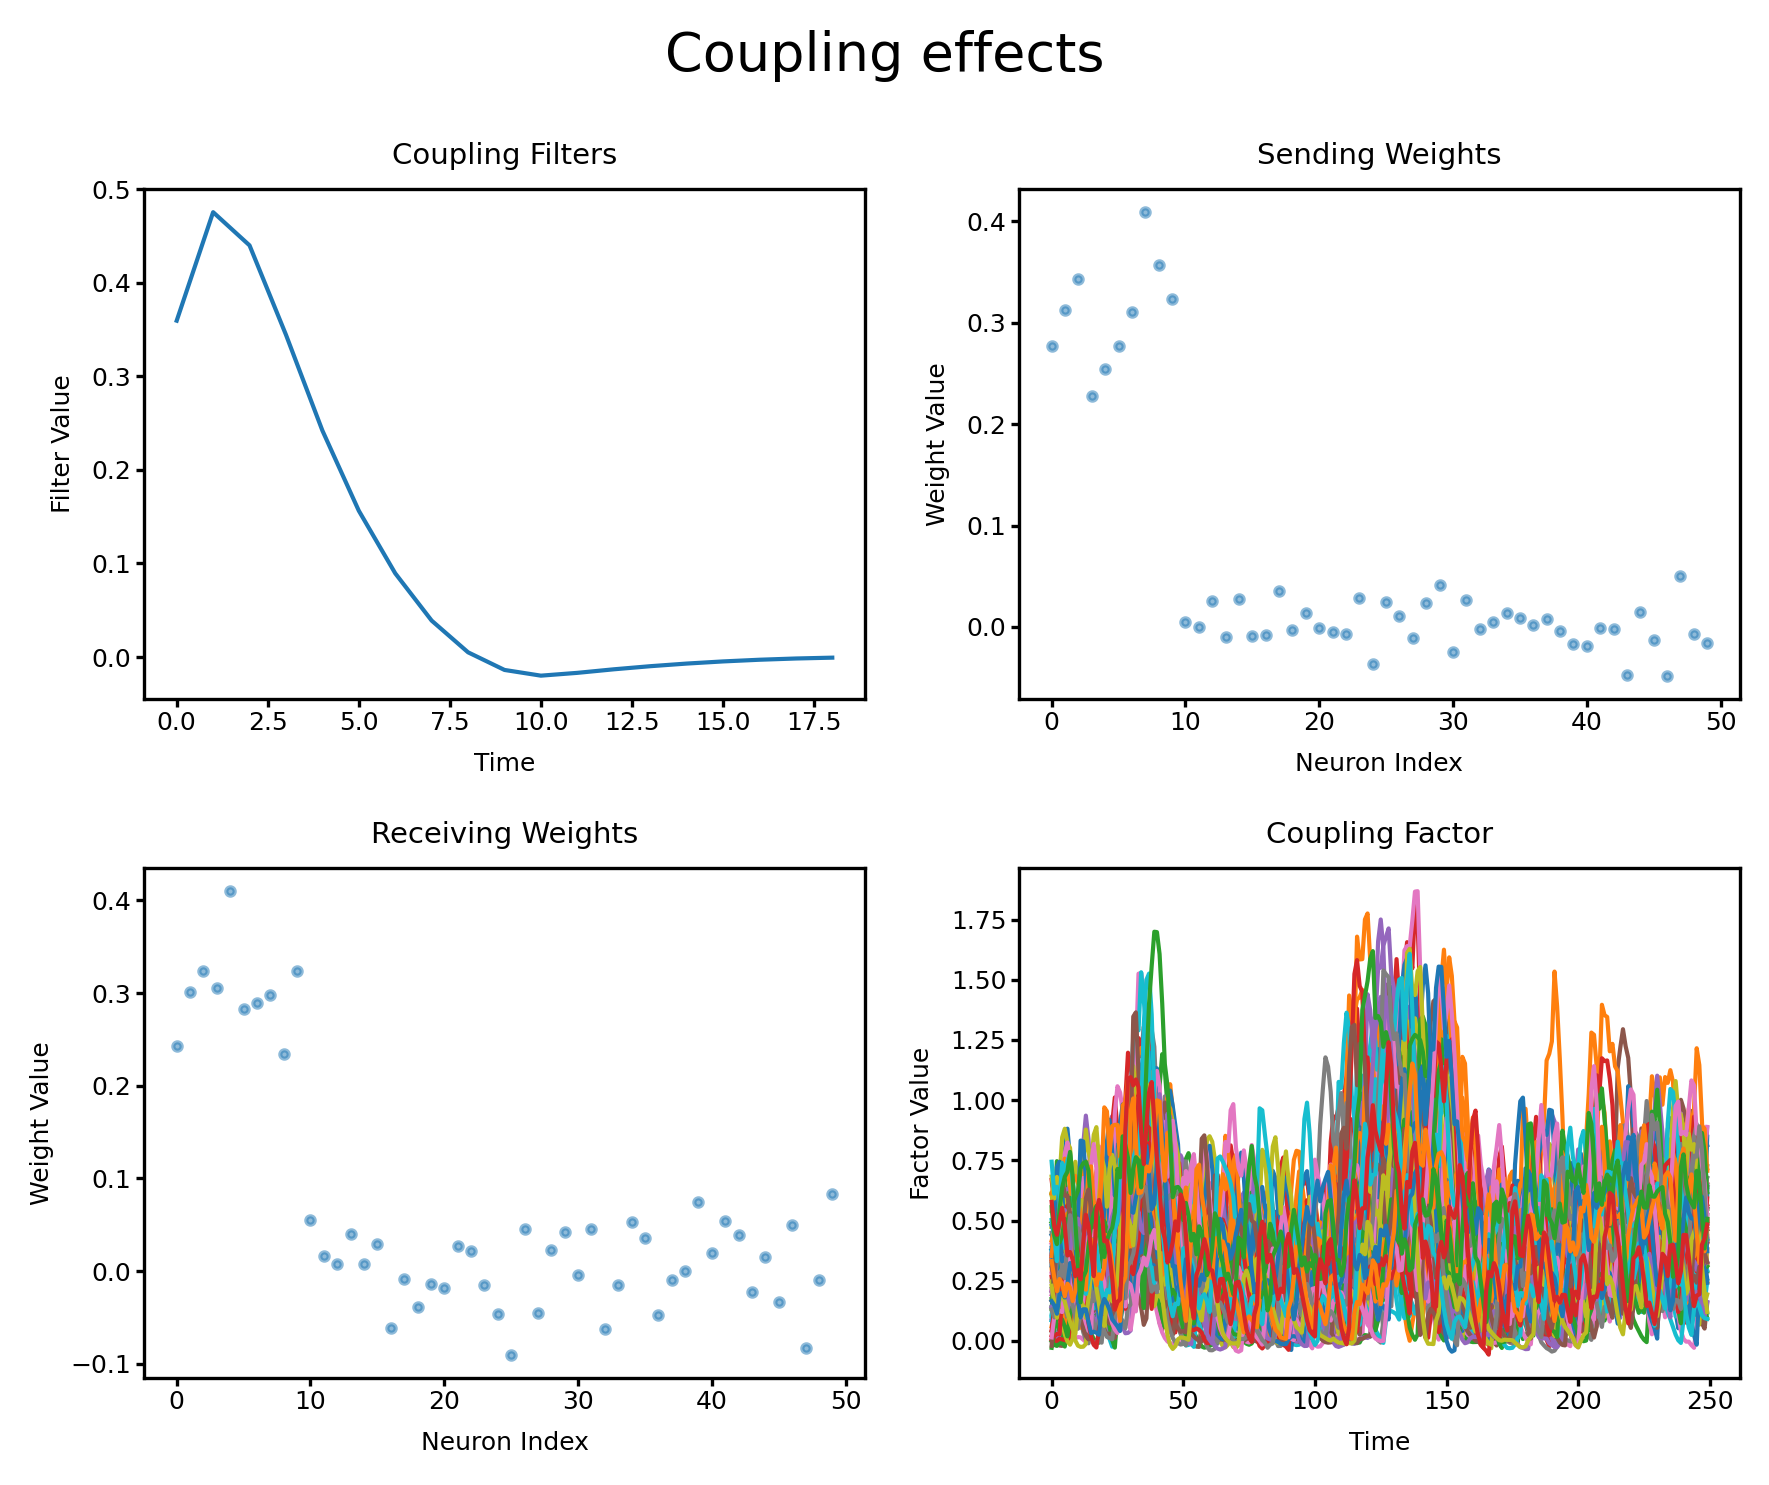

In [155]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Coupling effects', 
    fontsize=13
)

# Plot coupling filters
axes[0,0].plot(trainer.model.coupling_filters_dict["0"][0][1].cpu().numpy())
axes[0,0].set_title('Coupling Filters')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Filter Value')

# Plot sending weights 
axes[0,1].plot(trainer.model.cp_weight_sending_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[0,1].set_title('Sending Weights')
axes[0,1].set_xlabel('Neuron Index')
axes[0,1].set_ylabel('Weight Value')

# Plot receiving weights
axes[1,0].plot(trainer.model.cp_weight_receiving_dict["0"][0][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[1,0].set_title('Receiving Weights')
axes[1,0].set_xlabel('Neuron Index') 
axes[1,0].set_ylabel('Weight Value')

# Plot coupling factor
axes[1,1].plot(trainer.model.coupling_outputs_subspace[0][1].detach().cpu().numpy()[:,0,:].T)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Factor Value')

plt.tight_layout()


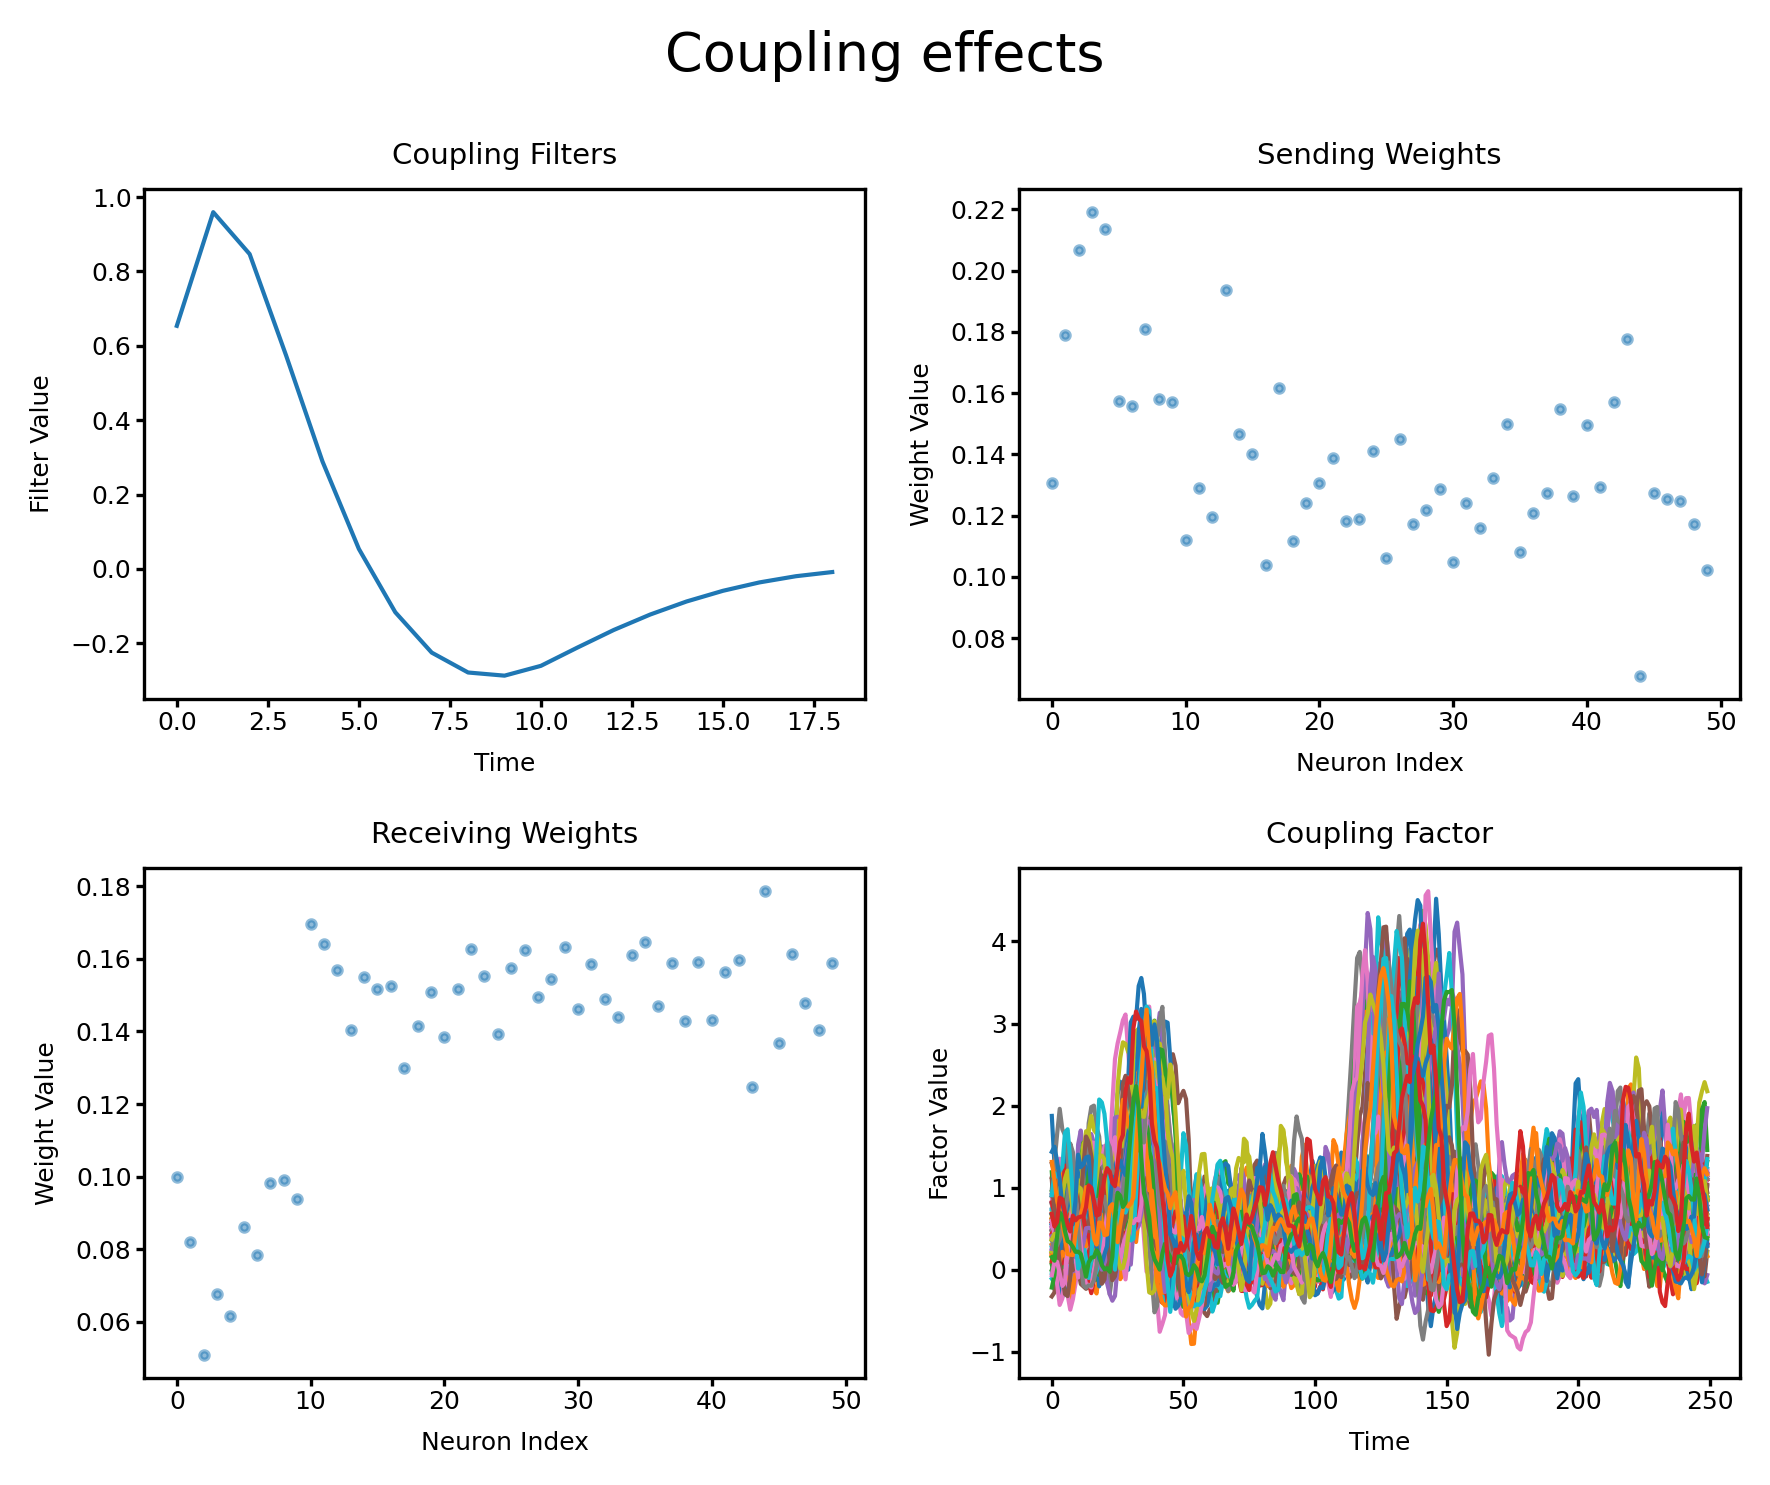

In [156]:
fig, axes = plt.subplots(2, 2, figsize=(6, 5), dpi=300)
fig.suptitle(
    'Coupling effects', 
    fontsize=13
)

# Plot coupling filters
axes[0,0].plot(trainer.model.coupling_filters_dict["0"][1][1].cpu().numpy())
axes[0,0].set_title('Coupling Filters')
axes[0,0].set_xlabel('Time')
axes[0,0].set_ylabel('Filter Value')

# Plot sending weights 
axes[0,1].plot(trainer.model.cp_weight_sending_dict["0"][1][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[0,1].set_title('Sending Weights')
axes[0,1].set_xlabel('Neuron Index')
axes[0,1].set_ylabel('Weight Value')

# Plot receiving weights
axes[1,0].plot(trainer.model.cp_weight_receiving_dict["0"][1][1].detach().cpu().numpy(), 
             "o", markersize=2, alpha=0.5)
axes[1,0].set_title('Receiving Weights')
axes[1,0].set_xlabel('Neuron Index') 
axes[1,0].set_ylabel('Weight Value')

# Plot coupling factor
axes[1,1].plot(trainer.model.coupling_outputs_subspace[1][1].detach().cpu().numpy()[:,0,:].T)
axes[1,1].set_title('Coupling Factor')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Factor Value')

plt.tight_layout()


# Different connection strength

In [6]:
######### Settings (need to run even if the data is already generated) #########
external_input_params = {
    "external_input_type": "two_peaks_with_all_varying",
    "std1": 10,
    "corr1": 0.5,
    "std2": 25,
    "corr2": 0.5,
    "use_two_modes": False,
    "gp_time_constant": 300,
    "gp_amplitude": 0.05,
}

# conn = 0.0
nneuron_coupling = 10
nneuron = 100
nneuron_part = nneuron//2
npadding = 50

In [ ]:
########## Generate synthetic data (no need to run) ###########
for conn in [0, 0.1, 0.2]:
    spikes, trial_info, I_ext, I_syn = GLM.EIF_simulator(
        ntrial=2000,
        nneuron=nneuron,
        conn=conn,
        nneuron_coupling=nneuron_coupling,
        params=external_input_params, 
        return_trial_info=True,
        return_I_ext=True,
        return_I_syn=True,
    )
    file_name = f'/home/qix/user_data/EIF_simulation_dataset/synthetic_data_EIF_conn={str(conn)}.npz'
    np.savez_compressed(file_name,
                        spikes=spikes,
                        trial_info=trial_info,
                        I_ext=I_ext,
                        I_syn=I_syn)



100%|██████████| 2000/2000 [02:53<00:00, 11.53it/s]


In [7]:
rcd_for_plot = {}
for conn in [0.0, 0.1, 0.2]:
    load_data_name = f'/home/qix/user_data/EIF_simulation_dataset/synthetic_data_EIF_conn={str(conn)}.npz'
    # load_data_name = '/home/qix/user_data/EIF_simulation_dataset/synthetic_data_EIF_connFalse.npz'

    data = np.load(load_data_name, allow_pickle=True)
    spikes = data['spikes']
    trial_info = data['trial_info']
    I_ext = data['I_ext']
    I_syn = data['I_syn']

    synthetic_dataloader = Simple_dataloader_from_spikes(
        [spikes[:,:nneuron_part,:], spikes[:,nneuron_part:,:]],
        npadding=50,
        train_ratio=0.7,
        val_ratio=0.1,
        batch_size=64,
        verbose=True
    )

    FIT_THE_BASELINE_MODEL = False

    # data_to_use = cross_session_dataloader
    data_to_use = synthetic_dataloader
    ckp_path = '/home/qix/user_data/VAETransformer_checkpoint'

    params = {
        # B-spline basis
        'num_B_spline_basis': 20,
        # Transformer VAE's settings
        'downsample_factor': 10,
        'transformer_num_layers': 2,
        'transformer_d_model': 128,
        'transformer_dim_feedforward': 512,
        'transformer_vae_output_dim': 16,
        'transformer_dropout': 0.0,
        'transformer_nhead': 1,
        'stimulus_nfactor': 1,
        'stimulus_decoder_inter_dim_factor': 2,
        'beta': 1.0,
        'use_area_specific_decoder': True,
        'use_area_specific_encoder': True,
        'use_cls': False,
        # Coupling's settings
        'coupling_basis_peaks_max': 5,
        'coupling_basis_num': 3,
        'coupling_nsubspace': 1,
        'use_self_coupling': True,
        # Coupling strength latent's settings
        'K_sigma2': 1.0,
        'K_tau': 100,
        'coupling_strength_nlatent': 1,
        # Self-history's settings
        'self_history_basis_peaks_max': 1.5,
        'self_history_basis_num': 3,
        'self_history_basis_nonlinear': 1,
        # Penalty settings
        'penalty_smoothing_spline': 1e2,
        'penalty_coupling_subgroup': 1e-5,
        'penalty_diff_loading': None,
        'penalty_loading_similarity': None,
        # Training settings
        'batch_size': 64,
        'sample_latent': False,
        'lr': 1e-3,
        'epoch_warm_up': 0,
        'epoch_patience': 3,
        'epoch_max': 200,
        'tol': 1e-5,
        'weight_decay': 0,
        'lr_transformer': 1e-4,
        'lr_sti': 1e-2,
        'lr_cp': 1e-2,
        'lr_self_history': 1e-2,
    }

    trainer = Trainer(data_to_use, ckp_path, params)

    if FIT_THE_BASELINE_MODEL:
        # Baseline model: no trial-varying stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=True,
            fix_latents=True,
            verbose=True,
        )

    else:
        # First step: train the model with a trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=True,
            fix_latents=True,
            verbose=True,
        )
        # Second step: train the model with a trial-varying stimulus effect
        # trainer.make_optimizer(frozen_params=['sti_readout'])
        trainer.make_optimizer(frozen_params=['sti_inhomo', ]) # We are fixing the trial-invariant stimulus effect
        trainer.train(
            include_stimulus=True,
            include_coupling=False,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
        )

        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
        )

        # trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter'])
        trainer.make_optimizer(frozen_params=['transformer_encoder', 'to_latent', 'token_converter',
            'sti_readout', 'sti_decoder', 'sti_inhomo', 'cp_latents_readout', 'cp_time_varying_coef_offset', 
            'cp_beta_coupling', 'cp_weight_sending', 'cp_weight_receiving'])
        # trainer.make_optimizer(frozen_params=[])
        trainer.train(
            include_stimulus=True,
            include_coupling=True,
            include_self_history=True,
            fix_stimulus=False,
            fix_latents=True,
            verbose=True,
            record_results=True,
        )


    ### Which dataset to use?
    loader = trainer.dataloader.test_loader

    ###
    trainer.model.normalize_coupling_coefficients()
    trainer.model.eval()
    trainer.model.sample_latent = False
    test_loss = 0.0
    test_loss_baseline = 0.0
    total_trial = 0
    test_loss_record = []
    with torch.no_grad():
        for i, batch in enumerate(tqdm(loader)):
            trainer.process_batch(batch)
            firing_rate = trainer.model(
                batch,
                include_stimulus=True,
                include_coupling=True,
                fix_stimulus=False,
                fix_latents=True,
            )
            loss = trainer.model.loss_function(
                firing_rate, 
                batch["spike_trains"][trainer.npadding:,:,:], 
                trainer.model.sti_mu, 
                trainer.model.sti_logvar, 
                beta=trainer.params['beta']
            )
            test_loss_record.append(loss.item())
            test_loss += loss.item() * batch["spike_trains"].size(2)
            total_trial += batch["spike_trains"].size(2)
            if i==0 or firing_rate_baseline.shape != batch["spike_trains"][trainer.npadding:,:,:].shape:
                firing_rate_baseline = (
                    torch.log(torch.clamp(batch["spike_trains"][trainer.npadding:,:,:].mean(dim=(0,2)), min=1e-4))[None,:,None] \
                        * torch.ones_like(batch["spike_trains"][trainer.npadding:,:,:])
                )
            
            loss_baseline = trainer.model.loss_function(
                firing_rate_baseline, 
                batch["spike_trains"][trainer.npadding:,:,:], 
                trainer.model.sti_mu, 
                trainer.model.sti_logvar, 
                beta=trainer.params['beta']
            )
            test_loss_baseline += loss_baseline.item() * batch["spike_trains"].size(2)

    test_loss /= total_trial
    test_loss_baseline /= total_trial
    print(f"Test loss: {test_loss}")
    print(f"Test loss baseline: {test_loss_baseline}")

    firing_rate_test, sti_mu_test, sti_logvar_test, trial_indices, spike_train_test = trainer.predict(
        dataset='test',
        batch_indices=[0],
        include_stimulus=True,
        include_coupling=True,
        fix_stimulus=False,
        fix_latents=True,
        return_torch=True,
        return_trial_indices=True,
        return_spike_trains=True,
    )

    neuron_indices = np.arange(nneuron_part,nneuron_part+nneuron_part)
    rcd_for_plot[conn] = {
        'I_ext': I_ext[:, :, trial_indices][:, neuron_indices, :],
        'I_syn': I_syn[:, :, trial_indices][:, neuron_indices, :],
        'firing_rates_stimulus': trainer.model.firing_rates_stimulus[:, neuron_indices, :].cpu().numpy().transpose(2,1,0),
        'firing_rates_coupling': trainer.model.coupling_outputs[0][1][:, :, :].cpu().numpy().transpose(2,1,0),
    }

/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1

100%|██████████| 4/4 [00:00<00:00, 176.81it/s]


Epoch 1/200, Train Loss: 0.8744, Test Loss: 0.7389


100%|██████████| 4/4 [00:00<00:00, 286.62it/s]


Epoch 2/200, Train Loss: 0.6205, Test Loss: 0.4982


100%|██████████| 4/4 [00:00<00:00, 284.03it/s]


Epoch 3/200, Train Loss: 0.4141, Test Loss: 0.3392


100%|██████████| 4/4 [00:00<00:00, 272.78it/s]


Epoch 4/200, Train Loss: 0.3005, Test Loss: 0.2697


100%|██████████| 4/4 [00:00<00:00, 265.11it/s]


Epoch 5/200, Train Loss: 0.2557, Test Loss: 0.2446


100%|██████████| 4/4 [00:00<00:00, 211.51it/s]


Epoch 6/200, Train Loss: 0.2393, Test Loss: 0.2348


100%|██████████| 4/4 [00:00<00:00, 264.52it/s]


Epoch 7/200, Train Loss: 0.2325, Test Loss: 0.2305


100%|██████████| 4/4 [00:00<00:00, 241.78it/s]


Epoch 8/200, Train Loss: 0.2293, Test Loss: 0.2282


100%|██████████| 4/4 [00:00<00:00, 270.04it/s]


Epoch 9/200, Train Loss: 0.2275, Test Loss: 0.2269


100%|██████████| 4/4 [00:00<00:00, 263.56it/s]


Epoch 10/200, Train Loss: 0.2265, Test Loss: 0.2261


100%|██████████| 4/4 [00:00<00:00, 259.34it/s]


Epoch 11/200, Train Loss: 0.2258, Test Loss: 0.2256


100%|██████████| 4/4 [00:00<00:00, 267.66it/s]


Epoch 12/200, Train Loss: 0.2254, Test Loss: 0.2252


100%|██████████| 4/4 [00:00<00:00, 176.09it/s]


Epoch 13/200, Train Loss: 0.2251, Test Loss: 0.2250


100%|██████████| 4/4 [00:00<00:00, 191.55it/s]


Epoch 14/200, Train Loss: 0.2249, Test Loss: 0.2248


100%|██████████| 4/4 [00:00<00:00, 268.41it/s]


Epoch 15/200, Train Loss: 0.2247, Test Loss: 0.2246


100%|██████████| 4/4 [00:00<00:00, 226.84it/s]


Epoch 16/200, Train Loss: 0.2245, Test Loss: 0.2245


100%|██████████| 4/4 [00:00<00:00, 273.66it/s]


Epoch 17/200, Train Loss: 0.2244, Test Loss: 0.2244


100%|██████████| 4/4 [00:00<00:00, 270.62it/s]


Epoch 18/200, Train Loss: 0.2243, Test Loss: 0.2243


100%|██████████| 4/4 [00:00<00:00, 264.23it/s]


Epoch 19/200, Train Loss: 0.2242, Test Loss: 0.2242


100%|██████████| 4/4 [00:00<00:00, 184.60it/s]


Epoch 20/200, Train Loss: 0.2241, Test Loss: 0.2241


100%|██████████| 4/4 [00:00<00:00, 164.19it/s]


Epoch 21/200, Train Loss: 0.2240, Test Loss: 0.2240


100%|██████████| 4/4 [00:00<00:00, 251.41it/s]


Epoch 22/200, Train Loss: 0.2240, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 259.05it/s]


Epoch 23/200, Train Loss: 0.2239, Test Loss: 0.2239


100%|██████████| 4/4 [00:00<00:00, 263.25it/s]


Epoch 24/200, Train Loss: 0.2238, Test Loss: 0.2238


100%|██████████| 4/4 [00:00<00:00, 266.39it/s]


Epoch 25/200, Train Loss: 0.2238, Test Loss: 0.2238


100%|██████████| 4/4 [00:00<00:00, 266.43it/s]


Epoch 26/200, Train Loss: 0.2237, Test Loss: 0.2237


100%|██████████| 4/4 [00:00<00:00, 278.01it/s]


Epoch 27/200, Train Loss: 0.2237, Test Loss: 0.2237


100%|██████████| 4/4 [00:00<00:00, 268.83it/s]


Epoch 28/200, Train Loss: 0.2237, Test Loss: 0.2236


100%|██████████| 4/4 [00:00<00:00, 279.25it/s]


Epoch 29/200, Train Loss: 0.2236, Test Loss: 0.2236


100%|██████████| 4/4 [00:00<00:00, 262.37it/s]


Epoch 30/200, Train Loss: 0.2236, Test Loss: 0.2236


100%|██████████| 4/4 [00:00<00:00, 241.57it/s]


Epoch 31/200, Train Loss: 0.2236, Test Loss: 0.2235


100%|██████████| 4/4 [00:00<00:00, 173.48it/s]


Epoch 32/200, Train Loss: 0.2235, Test Loss: 0.2235


100%|██████████| 4/4 [00:00<00:00, 212.52it/s]


Epoch 33/200, Train Loss: 0.2235, Test Loss: 0.2235


100%|██████████| 4/4 [00:00<00:00, 239.72it/s]


Epoch 34/200, Train Loss: 0.2235, Test Loss: 0.2235


100%|██████████| 4/4 [00:00<00:00, 268.06it/s]


Epoch 35/200, Train Loss: 0.2234, Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 256.52it/s]


Epoch 36/200, Train Loss: 0.2234, Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 276.13it/s]


Epoch 37/200, Train Loss: 0.2234, Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 273.69it/s]


Epoch 38/200, Train Loss: 0.2234, Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 193.60it/s]


Epoch 39/200, Train Loss: 0.2234, Test Loss: 0.2234


100%|██████████| 4/4 [00:00<00:00, 130.33it/s]


Epoch 40/200, Train Loss: 0.2234, Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 267.65it/s]


Epoch 41/200, Train Loss: 0.2233, Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 278.60it/s]


Epoch 42/200, Train Loss: 0.2233, Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 277.94it/s]


Epoch 43/200, Train Loss: 0.2233, Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 275.70it/s]


Epoch 44/200, Train Loss: 0.2233, Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 277.68it/s]


Epoch 45/200, Train Loss: 0.2233, Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 278.15it/s]


Epoch 46/200, Train Loss: 0.2233, Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 271.15it/s]


Epoch 47/200, Train Loss: 0.2233, Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 279.40it/s]


Epoch 48/200, Train Loss: 0.2233, Test Loss: 0.2233
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2233


100%|██████████| 4/4 [00:00<00:00, 269.64it/s]


Epoch 49/200, Train Loss: 0.2232, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 214.78it/s]


Epoch 50/200, Train Loss: 0.2232, Test Loss: 0.2232
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 273.85it/s]


Epoch 51/200, Train Loss: 0.2232, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 267.99it/s]


Epoch 52/200, Train Loss: 0.2232, Test Loss: 0.2232
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 271.58it/s]


Epoch 53/200, Train Loss: 0.2232, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 279.89it/s]


Epoch 54/200, Train Loss: 0.2232, Test Loss: 0.2232
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 285.00it/s]


Epoch 55/200, Train Loss: 0.2232, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 277.55it/s]


Epoch 56/200, Train Loss: 0.2232, Test Loss: 0.2232
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 265.53it/s]


Epoch 57/200, Train Loss: 0.2232, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 251.70it/s]


Epoch 58/200, Train Loss: 0.2232, Test Loss: 0.2232
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 178.17it/s]


Epoch 59/200, Train Loss: 0.2232, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 252.25it/s]


Epoch 60/200, Train Loss: 0.2232, Test Loss: 0.2232
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 246.30it/s]


Epoch 61/200, Train Loss: 0.2232, Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 258.01it/s]


Epoch 62/200, Train Loss: 0.2232, Test Loss: 0.2231
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2232


100%|██████████| 4/4 [00:00<00:00, 234.36it/s]


Epoch 63/200, Train Loss: 0.2231, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 192.43it/s]


Epoch 64/200, Train Loss: 0.2231, Test Loss: 0.2231
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 167.84it/s]


Epoch 65/200, Train Loss: 0.2231, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 254.17it/s]


Epoch 66/200, Train Loss: 0.2231, Test Loss: 0.2231
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 150.52it/s]


Epoch 67/200, Train Loss: 0.2231, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 152.44it/s]


Epoch 68/200, Train Loss: 0.2231, Test Loss: 0.2231
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 217.87it/s]


Epoch 69/200, Train Loss: 0.2231, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 249.73it/s]


Epoch 70/200, Train Loss: 0.2231, Test Loss: 0.2231
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 275.42it/s]


Epoch 71/200, Train Loss: 0.2231, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 280.73it/s]


Epoch 72/200, Train Loss: 0.2231, Test Loss: 0.2231
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 270.64it/s]


Epoch 73/200, Train Loss: 0.2231, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 184.67it/s]


Epoch 74/200, Train Loss: 0.2231, Test Loss: 0.2231
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 142.77it/s]


Epoch 75/200, Train Loss: 0.2231, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 203.66it/s]


Epoch 76/200, Train Loss: 0.2231, Test Loss: 0.2231
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 137.20it/s]


Epoch 77/200, Train Loss: 0.2231, Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 280.13it/s]


Epoch 78/200, Train Loss: 0.2231, Test Loss: 0.2231
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 260.22it/s]


Epoch 79/200, Train Loss: 0.2231, Test Loss: 0.2231
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2231


100%|██████████| 4/4 [00:00<00:00, 273.12it/s]


Epoch 80/200, Train Loss: 0.2231, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 278.45it/s]


Epoch 81/200, Train Loss: 0.2231, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 276.70it/s]


Epoch 82/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 250.90it/s]


Epoch 83/200, Train Loss: 0.2230, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 267.40it/s]


Epoch 84/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 182.60it/s]


Epoch 85/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 157.23it/s]


Epoch 86/200, Train Loss: 0.2230, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 195.60it/s]


Epoch 87/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 152.50it/s]


Epoch 88/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 269.65it/s]


Epoch 89/200, Train Loss: 0.2230, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 243.21it/s]


Epoch 90/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 224.13it/s]


Epoch 91/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 146.79it/s]


Epoch 92/200, Train Loss: 0.2230, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 238.97it/s]


Epoch 93/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 254.47it/s]


Epoch 94/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 206.84it/s]


Epoch 95/200, Train Loss: 0.2230, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 258.27it/s]


Epoch 96/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 270.53it/s]


Epoch 97/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 270.43it/s]


Epoch 98/200, Train Loss: 0.2230, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 279.79it/s]


Epoch 99/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 251.93it/s]


Epoch 100/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 280.24it/s]


Epoch 101/200, Train Loss: 0.2230, Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 187.04it/s]


Epoch 102/200, Train Loss: 0.2230, Test Loss: 0.2230
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 278.13it/s]


Epoch 103/200, Train Loss: 0.2230, Test Loss: 0.2229
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2230


100%|██████████| 4/4 [00:00<00:00, 269.60it/s]


Epoch 104/200, Train Loss: 0.2230, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 273.35it/s]


Epoch 105/200, Train Loss: 0.2230, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 260.68it/s]


Epoch 106/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 239.99it/s]


Epoch 107/200, Train Loss: 0.2229, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 180.04it/s]


Epoch 108/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 187.94it/s]


Epoch 109/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 262.85it/s]


Epoch 110/200, Train Loss: 0.2229, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 222.07it/s]


Epoch 111/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 191.28it/s]


Epoch 112/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 217.88it/s]


Epoch 113/200, Train Loss: 0.2229, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 260.99it/s]


Epoch 114/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 139.28it/s]


Epoch 115/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 157.05it/s]


Epoch 116/200, Train Loss: 0.2229, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 210.67it/s]


Epoch 117/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 278.62it/s]


Epoch 118/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 275.08it/s]


Epoch 119/200, Train Loss: 0.2229, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 160.38it/s]


Epoch 120/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 263.02it/s]


Epoch 121/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 273.40it/s]


Epoch 122/200, Train Loss: 0.2229, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 213.03it/s]


Epoch 123/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 211.36it/s]


Epoch 124/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 230.44it/s]


Epoch 125/200, Train Loss: 0.2229, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 252.52it/s]


Epoch 126/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 243.15it/s]


Epoch 127/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 276.28it/s]


Epoch 128/200, Train Loss: 0.2229, Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 274.38it/s]


Epoch 129/200, Train Loss: 0.2229, Test Loss: 0.2229
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 278.85it/s]


Epoch 130/200, Train Loss: 0.2229, Test Loss: 0.2228
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2229


100%|██████████| 4/4 [00:00<00:00, 273.17it/s]


Epoch 131/200, Train Loss: 0.2229, Test Loss: 0.2228


100%|██████████| 4/4 [00:00<00:00, 239.08it/s]


Epoch 132/200, Train Loss: 0.2229, Test Loss: 0.2228
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2228


100%|██████████| 4/4 [00:00<00:00, 216.82it/s]


Epoch 133/200, Train Loss: 0.2229, Test Loss: 0.2228
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2228


100%|██████████| 4/4 [00:00<00:00, 178.55it/s]
/home/qix/FC-GPFA/model_trainer.py:316: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(se

Epoch 134/200, Train Loss: 0.2229, Test Loss: 0.2228
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2228
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'bat

100%|██████████| 4/4 [00:00<00:00, 203.31it/s]


Epoch 1/200, Train Loss: 0.2219, Test Loss: 0.2196


100%|██████████| 4/4 [00:00<00:00, 199.04it/s]


Epoch 2/200, Train Loss: 0.2194, Test Loss: 0.2192


100%|██████████| 4/4 [00:00<00:00, 201.05it/s]


Epoch 3/200, Train Loss: 0.2192, Test Loss: 0.2190


100%|██████████| 4/4 [00:00<00:00, 213.88it/s]


Epoch 4/200, Train Loss: 0.2191, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 204.71it/s]


Epoch 5/200, Train Loss: 0.2190, Test Loss: 0.2189


100%|██████████| 4/4 [00:00<00:00, 160.68it/s]


Epoch 6/200, Train Loss: 0.2189, Test Loss: 0.2188


100%|██████████| 4/4 [00:00<00:00, 162.83it/s]


Epoch 7/200, Train Loss: 0.2187, Test Loss: 0.2186


100%|██████████| 4/4 [00:00<00:00, 201.00it/s]


Epoch 8/200, Train Loss: 0.2185, Test Loss: 0.2185


100%|██████████| 4/4 [00:00<00:00, 210.80it/s]


Epoch 9/200, Train Loss: 0.2182, Test Loss: 0.2183


100%|██████████| 4/4 [00:00<00:00, 217.92it/s]


Epoch 10/200, Train Loss: 0.2181, Test Loss: 0.2182


100%|██████████| 4/4 [00:00<00:00, 214.47it/s]


Epoch 11/200, Train Loss: 0.2180, Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 183.19it/s]


Epoch 12/200, Train Loss: 0.2179, Test Loss: 0.2180


100%|██████████| 4/4 [00:00<00:00, 200.62it/s]


Epoch 13/200, Train Loss: 0.2178, Test Loss: 0.2179


100%|██████████| 4/4 [00:00<00:00, 159.87it/s]


Epoch 14/200, Train Loss: 0.2178, Test Loss: 0.2177


100%|██████████| 4/4 [00:00<00:00, 129.16it/s]


Epoch 15/200, Train Loss: 0.2176, Test Loss: 0.2176


100%|██████████| 4/4 [00:00<00:00, 212.25it/s]


Epoch 16/200, Train Loss: 0.2175, Test Loss: 0.2174


100%|██████████| 4/4 [00:00<00:00, 191.39it/s]


Epoch 17/200, Train Loss: 0.2172, Test Loss: 0.2171


100%|██████████| 4/4 [00:00<00:00, 186.24it/s]


Epoch 18/200, Train Loss: 0.2170, Test Loss: 0.2169


100%|██████████| 4/4 [00:00<00:00, 72.28it/s]


Epoch 19/200, Train Loss: 0.2169, Test Loss: 0.2168


100%|██████████| 4/4 [00:00<00:00, 142.73it/s]


Epoch 20/200, Train Loss: 0.2168, Test Loss: 0.2168


100%|██████████| 4/4 [00:00<00:00, 197.31it/s]


Epoch 21/200, Train Loss: 0.2167, Test Loss: 0.2167


100%|██████████| 4/4 [00:00<00:00, 205.14it/s]


Epoch 22/200, Train Loss: 0.2166, Test Loss: 0.2166


100%|██████████| 4/4 [00:00<00:00, 190.60it/s]


Epoch 23/200, Train Loss: 0.2165, Test Loss: 0.2166


100%|██████████| 4/4 [00:00<00:00, 194.28it/s]


Epoch 24/200, Train Loss: 0.2165, Test Loss: 0.2166


100%|██████████| 4/4 [00:00<00:00, 202.73it/s]


Epoch 25/200, Train Loss: 0.2165, Test Loss: 0.2165


100%|██████████| 4/4 [00:00<00:00, 99.37it/s]


Epoch 26/200, Train Loss: 0.2164, Test Loss: 0.2165


100%|██████████| 4/4 [00:00<00:00, 216.17it/s]


Epoch 27/200, Train Loss: 0.2164, Test Loss: 0.2165


100%|██████████| 4/4 [00:00<00:00, 205.82it/s]


Epoch 28/200, Train Loss: 0.2164, Test Loss: 0.2165
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2165


100%|██████████| 4/4 [00:00<00:00, 207.83it/s]


Epoch 29/200, Train Loss: 0.2164, Test Loss: 0.2164


100%|██████████| 4/4 [00:00<00:00, 206.17it/s]


Epoch 30/200, Train Loss: 0.2164, Test Loss: 0.2164
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2164


100%|██████████| 4/4 [00:00<00:00, 203.48it/s]


Epoch 31/200, Train Loss: 0.2162, Test Loss: 0.2163


100%|██████████| 4/4 [00:00<00:00, 218.01it/s]


Epoch 32/200, Train Loss: 0.2162, Test Loss: 0.2162


100%|██████████| 4/4 [00:00<00:00, 217.47it/s]


Epoch 33/200, Train Loss: 0.2161, Test Loss: 0.2162


100%|██████████| 4/4 [00:00<00:00, 222.45it/s]


Epoch 34/200, Train Loss: 0.2161, Test Loss: 0.2162


100%|██████████| 4/4 [00:00<00:00, 174.34it/s]


Epoch 35/200, Train Loss: 0.2161, Test Loss: 0.2161


100%|██████████| 4/4 [00:00<00:00, 159.18it/s]


Epoch 36/200, Train Loss: 0.2160, Test Loss: 0.2161


100%|██████████| 4/4 [00:00<00:00, 221.17it/s]


Epoch 37/200, Train Loss: 0.2160, Test Loss: 0.2161


100%|██████████| 4/4 [00:00<00:00, 101.80it/s]


Epoch 38/200, Train Loss: 0.2160, Test Loss: 0.2161


100%|██████████| 4/4 [00:00<00:00, 223.72it/s]


Epoch 39/200, Train Loss: 0.2160, Test Loss: 0.2160


100%|██████████| 4/4 [00:00<00:00, 208.43it/s]


Epoch 40/200, Train Loss: 0.2159, Test Loss: 0.2160


100%|██████████| 4/4 [00:00<00:00, 160.63it/s]


Epoch 41/200, Train Loss: 0.2159, Test Loss: 0.2160
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2160


100%|██████████| 4/4 [00:00<00:00, 160.36it/s]


Epoch 42/200, Train Loss: 0.2159, Test Loss: 0.2160


100%|██████████| 4/4 [00:00<00:00, 182.68it/s]


Epoch 43/200, Train Loss: 0.2159, Test Loss: 0.2160


100%|██████████| 4/4 [00:00<00:00, 204.32it/s]


Epoch 44/200, Train Loss: 0.2158, Test Loss: 0.2159


100%|██████████| 4/4 [00:00<00:00, 143.01it/s]


Epoch 45/200, Train Loss: 0.2158, Test Loss: 0.2159


100%|██████████| 4/4 [00:00<00:00, 206.10it/s]


Epoch 46/200, Train Loss: 0.2158, Test Loss: 0.2159


100%|██████████| 4/4 [00:00<00:00, 220.33it/s]


Epoch 47/200, Train Loss: 0.2158, Test Loss: 0.2159


100%|██████████| 4/4 [00:00<00:00, 208.35it/s]


Epoch 48/200, Train Loss: 0.2158, Test Loss: 0.2159


100%|██████████| 4/4 [00:00<00:00, 210.27it/s]


Epoch 49/200, Train Loss: 0.2158, Test Loss: 0.2159
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2159


100%|██████████| 4/4 [00:00<00:00, 214.34it/s]


Epoch 50/200, Train Loss: 0.2157, Test Loss: 0.2159


100%|██████████| 4/4 [00:00<00:00, 139.29it/s]


Epoch 51/200, Train Loss: 0.2157, Test Loss: 0.2159


100%|██████████| 4/4 [00:00<00:00, 181.86it/s]


Epoch 52/200, Train Loss: 0.2157, Test Loss: 0.2158


100%|██████████| 4/4 [00:00<00:00, 154.20it/s]


Epoch 53/200, Train Loss: 0.2157, Test Loss: 0.2158


100%|██████████| 4/4 [00:00<00:00, 65.77it/s]


Epoch 54/200, Train Loss: 0.2157, Test Loss: 0.2158
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2158


100%|██████████| 4/4 [00:00<00:00, 204.19it/s]


Epoch 55/200, Train Loss: 0.2157, Test Loss: 0.2158


100%|██████████| 4/4 [00:00<00:00, 163.51it/s]


Epoch 56/200, Train Loss: 0.2156, Test Loss: 0.2158


100%|██████████| 4/4 [00:00<00:00, 211.36it/s]


Epoch 57/200, Train Loss: 0.2156, Test Loss: 0.2158


100%|██████████| 4/4 [00:00<00:00, 194.32it/s]


Epoch 58/200, Train Loss: 0.2156, Test Loss: 0.2158
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2158


100%|██████████| 4/4 [00:00<00:00, 153.24it/s]


Epoch 59/200, Train Loss: 0.2156, Test Loss: 0.2158


100%|██████████| 4/4 [00:00<00:00, 215.55it/s]


Epoch 60/200, Train Loss: 0.2156, Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 184.43it/s]


Epoch 61/200, Train Loss: 0.2156, Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 210.09it/s]


Epoch 62/200, Train Loss: 0.2156, Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 199.84it/s]


Epoch 63/200, Train Loss: 0.2156, Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 198.51it/s]


Epoch 64/200, Train Loss: 0.2156, Test Loss: 0.2157
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 142.79it/s]


Epoch 65/200, Train Loss: 0.2156, Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 211.57it/s]


Epoch 66/200, Train Loss: 0.2155, Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 208.92it/s]


Epoch 67/200, Train Loss: 0.2155, Test Loss: 0.2157
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 201.41it/s]


Epoch 68/200, Train Loss: 0.2155, Test Loss: 0.2157
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2157


100%|██████████| 4/4 [00:00<00:00, 219.14it/s]


Epoch 69/200, Train Loss: 0.2155, Test Loss: 0.2157
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2157
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batc

100%|██████████| 4/4 [00:00<00:00, 139.87it/s]


Epoch 1/200, Train Loss: 0.2158, Test Loss: 0.2156


100%|██████████| 4/4 [00:00<00:00, 180.15it/s]


Epoch 2/200, Train Loss: 0.2153, Test Loss: 0.2151


100%|██████████| 4/4 [00:00<00:00, 166.64it/s]


Epoch 3/200, Train Loss: 0.2149, Test Loss: 0.2149


100%|██████████| 4/4 [00:00<00:00, 180.88it/s]


Epoch 4/200, Train Loss: 0.2148, Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 173.94it/s]


Epoch 5/200, Train Loss: 0.2148, Test Loss: 0.2148
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 152.81it/s]


Epoch 6/200, Train Loss: 0.2148, Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 147.89it/s]


Epoch 7/200, Train Loss: 0.2148, Test Loss: 0.2148
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 176.95it/s]


Epoch 8/200, Train Loss: 0.2147, Test Loss: 0.2148
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 174.82it/s]


Epoch 9/200, Train Loss: 0.2147, Test Loss: 0.2148
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2148
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batch

100%|██████████| 4/4 [00:00<00:00, 135.07it/s]


Epoch 1/200, Train Loss: 0.2147, Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 181.67it/s]


Epoch 2/200, Train Loss: 0.2147, Test Loss: 0.2148
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 175.01it/s]


Epoch 3/200, Train Loss: 0.2147, Test Loss: 0.2148
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2148


100%|██████████| 4/4 [00:00<00:00, 176.70it/s]


Epoch 4/200, Train Loss: 0.2147, Test Loss: 0.2148
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2148
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 175.93it/s]


Test loss: 0.22610880876717127
Test loss baseline: 0.2318766810501603


/home/qix/anaconda3/envs/allen/lib/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.001, 'epoch_warm_up': 0, 'epoch_patience': 3, 'epoch_max': 200, 'tol': 1

100%|██████████| 4/4 [00:00<00:00, 244.65it/s]


Epoch 1/200, Train Loss: 0.8719, Test Loss: 0.7370


100%|██████████| 4/4 [00:00<00:00, 284.98it/s]


Epoch 2/200, Train Loss: 0.6221, Test Loss: 0.5032


100%|██████████| 4/4 [00:00<00:00, 273.20it/s]


Epoch 3/200, Train Loss: 0.4220, Test Loss: 0.3508


100%|██████████| 4/4 [00:00<00:00, 221.53it/s]


Epoch 4/200, Train Loss: 0.3125, Test Loss: 0.2843


100%|██████████| 4/4 [00:00<00:00, 136.08it/s]


Epoch 5/200, Train Loss: 0.2692, Test Loss: 0.2601


100%|██████████| 4/4 [00:00<00:00, 264.98it/s]


Epoch 6/200, Train Loss: 0.2532, Test Loss: 0.2507


100%|██████████| 4/4 [00:00<00:00, 282.73it/s]


Epoch 7/200, Train Loss: 0.2466, Test Loss: 0.2464


100%|██████████| 4/4 [00:00<00:00, 260.59it/s]


Epoch 8/200, Train Loss: 0.2434, Test Loss: 0.2441


100%|██████████| 4/4 [00:00<00:00, 271.16it/s]


Epoch 9/200, Train Loss: 0.2416, Test Loss: 0.2428


100%|██████████| 4/4 [00:00<00:00, 212.02it/s]


Epoch 10/200, Train Loss: 0.2406, Test Loss: 0.2420


100%|██████████| 4/4 [00:00<00:00, 138.41it/s]


Epoch 11/200, Train Loss: 0.2399, Test Loss: 0.2415


100%|██████████| 4/4 [00:00<00:00, 209.83it/s]


Epoch 12/200, Train Loss: 0.2394, Test Loss: 0.2411


100%|██████████| 4/4 [00:00<00:00, 275.31it/s]


Epoch 13/200, Train Loss: 0.2391, Test Loss: 0.2408


100%|██████████| 4/4 [00:00<00:00, 260.04it/s]


Epoch 14/200, Train Loss: 0.2388, Test Loss: 0.2406


100%|██████████| 4/4 [00:00<00:00, 140.49it/s]


Epoch 15/200, Train Loss: 0.2386, Test Loss: 0.2404


100%|██████████| 4/4 [00:00<00:00, 241.00it/s]


Epoch 16/200, Train Loss: 0.2385, Test Loss: 0.2402


100%|██████████| 4/4 [00:00<00:00, 209.95it/s]


Epoch 17/200, Train Loss: 0.2383, Test Loss: 0.2401


100%|██████████| 4/4 [00:00<00:00, 233.90it/s]


Epoch 18/200, Train Loss: 0.2382, Test Loss: 0.2400


100%|██████████| 4/4 [00:00<00:00, 234.48it/s]


Epoch 19/200, Train Loss: 0.2381, Test Loss: 0.2399


100%|██████████| 4/4 [00:00<00:00, 268.82it/s]


Epoch 20/200, Train Loss: 0.2380, Test Loss: 0.2398


100%|██████████| 4/4 [00:00<00:00, 172.93it/s]


Epoch 21/200, Train Loss: 0.2379, Test Loss: 0.2397


100%|██████████| 4/4 [00:00<00:00, 253.45it/s]


Epoch 22/200, Train Loss: 0.2378, Test Loss: 0.2397


100%|██████████| 4/4 [00:00<00:00, 174.29it/s]


Epoch 23/200, Train Loss: 0.2378, Test Loss: 0.2396


100%|██████████| 4/4 [00:00<00:00, 151.14it/s]


Epoch 24/200, Train Loss: 0.2377, Test Loss: 0.2395


100%|██████████| 4/4 [00:00<00:00, 223.72it/s]


Epoch 25/200, Train Loss: 0.2376, Test Loss: 0.2395


100%|██████████| 4/4 [00:00<00:00, 228.12it/s]


Epoch 26/200, Train Loss: 0.2376, Test Loss: 0.2394


100%|██████████| 4/4 [00:00<00:00, 263.37it/s]


Epoch 27/200, Train Loss: 0.2375, Test Loss: 0.2394


100%|██████████| 4/4 [00:00<00:00, 254.27it/s]


Epoch 28/200, Train Loss: 0.2375, Test Loss: 0.2393


100%|██████████| 4/4 [00:00<00:00, 250.17it/s]


Epoch 29/200, Train Loss: 0.2374, Test Loss: 0.2393


100%|██████████| 4/4 [00:00<00:00, 198.74it/s]


Epoch 30/200, Train Loss: 0.2374, Test Loss: 0.2392


100%|██████████| 4/4 [00:00<00:00, 263.29it/s]


Epoch 31/200, Train Loss: 0.2374, Test Loss: 0.2392


100%|██████████| 4/4 [00:00<00:00, 174.34it/s]


Epoch 32/200, Train Loss: 0.2373, Test Loss: 0.2392


100%|██████████| 4/4 [00:00<00:00, 246.35it/s]


Epoch 33/200, Train Loss: 0.2373, Test Loss: 0.2391


100%|██████████| 4/4 [00:00<00:00, 234.31it/s]


Epoch 34/200, Train Loss: 0.2373, Test Loss: 0.2391


100%|██████████| 4/4 [00:00<00:00, 263.66it/s]


Epoch 35/200, Train Loss: 0.2372, Test Loss: 0.2391


100%|██████████| 4/4 [00:00<00:00, 279.71it/s]


Epoch 36/200, Train Loss: 0.2372, Test Loss: 0.2390


100%|██████████| 4/4 [00:00<00:00, 280.25it/s]


Epoch 37/200, Train Loss: 0.2372, Test Loss: 0.2390


100%|██████████| 4/4 [00:00<00:00, 263.14it/s]


Epoch 38/200, Train Loss: 0.2372, Test Loss: 0.2390


100%|██████████| 4/4 [00:00<00:00, 263.46it/s]


Epoch 39/200, Train Loss: 0.2371, Test Loss: 0.2390


100%|██████████| 4/4 [00:00<00:00, 276.84it/s]


Epoch 40/200, Train Loss: 0.2371, Test Loss: 0.2389


100%|██████████| 4/4 [00:00<00:00, 269.63it/s]


Epoch 41/200, Train Loss: 0.2371, Test Loss: 0.2389


100%|██████████| 4/4 [00:00<00:00, 272.14it/s]


Epoch 42/200, Train Loss: 0.2371, Test Loss: 0.2389


100%|██████████| 4/4 [00:00<00:00, 281.25it/s]


Epoch 43/200, Train Loss: 0.2371, Test Loss: 0.2389


100%|██████████| 4/4 [00:00<00:00, 279.86it/s]


Epoch 44/200, Train Loss: 0.2370, Test Loss: 0.2388


100%|██████████| 4/4 [00:00<00:00, 271.02it/s]


Epoch 45/200, Train Loss: 0.2370, Test Loss: 0.2388


100%|██████████| 4/4 [00:00<00:00, 281.08it/s]


Epoch 46/200, Train Loss: 0.2370, Test Loss: 0.2388


100%|██████████| 4/4 [00:00<00:00, 275.76it/s]


Epoch 47/200, Train Loss: 0.2370, Test Loss: 0.2388


100%|██████████| 4/4 [00:00<00:00, 284.13it/s]


Epoch 48/200, Train Loss: 0.2370, Test Loss: 0.2388


100%|██████████| 4/4 [00:00<00:00, 263.05it/s]


Epoch 49/200, Train Loss: 0.2370, Test Loss: 0.2388


100%|██████████| 4/4 [00:00<00:00, 277.40it/s]


Epoch 50/200, Train Loss: 0.2369, Test Loss: 0.2388


100%|██████████| 4/4 [00:00<00:00, 284.60it/s]


Epoch 51/200, Train Loss: 0.2369, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 270.54it/s]


Epoch 52/200, Train Loss: 0.2369, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 273.32it/s]


Epoch 53/200, Train Loss: 0.2369, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 264.37it/s]


Epoch 54/200, Train Loss: 0.2369, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 266.75it/s]


Epoch 55/200, Train Loss: 0.2369, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 189.46it/s]


Epoch 56/200, Train Loss: 0.2369, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 167.20it/s]


Epoch 57/200, Train Loss: 0.2369, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 276.46it/s]


Epoch 58/200, Train Loss: 0.2368, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 276.45it/s]


Epoch 59/200, Train Loss: 0.2368, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 271.62it/s]


Epoch 60/200, Train Loss: 0.2368, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 142.85it/s]


Epoch 61/200, Train Loss: 0.2368, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 169.35it/s]


Epoch 62/200, Train Loss: 0.2368, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 218.96it/s]


Epoch 63/200, Train Loss: 0.2368, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 171.41it/s]


Epoch 64/200, Train Loss: 0.2368, Test Loss: 0.2386
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 187.59it/s]


Epoch 65/200, Train Loss: 0.2368, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 262.14it/s]


Epoch 66/200, Train Loss: 0.2368, Test Loss: 0.2386
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 268.72it/s]


Epoch 67/200, Train Loss: 0.2368, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 277.99it/s]


Epoch 68/200, Train Loss: 0.2368, Test Loss: 0.2385
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 271.21it/s]


Epoch 69/200, Train Loss: 0.2367, Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 251.53it/s]


Epoch 70/200, Train Loss: 0.2367, Test Loss: 0.2385
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 255.75it/s]


Epoch 71/200, Train Loss: 0.2367, Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 264.88it/s]


Epoch 72/200, Train Loss: 0.2367, Test Loss: 0.2385
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 250.72it/s]


Epoch 73/200, Train Loss: 0.2367, Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 257.66it/s]


Epoch 74/200, Train Loss: 0.2367, Test Loss: 0.2385
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 255.27it/s]


Epoch 75/200, Train Loss: 0.2367, Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 264.68it/s]


Epoch 76/200, Train Loss: 0.2367, Test Loss: 0.2385
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 266.06it/s]


Epoch 77/200, Train Loss: 0.2367, Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 270.80it/s]


Epoch 78/200, Train Loss: 0.2367, Test Loss: 0.2385
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 285.09it/s]


Epoch 79/200, Train Loss: 0.2367, Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 262.04it/s]


Epoch 80/200, Train Loss: 0.2367, Test Loss: 0.2385
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 274.15it/s]


Epoch 81/200, Train Loss: 0.2367, Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 280.20it/s]


Epoch 82/200, Train Loss: 0.2367, Test Loss: 0.2384
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 279.08it/s]


Epoch 83/200, Train Loss: 0.2366, Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 266.37it/s]


Epoch 84/200, Train Loss: 0.2366, Test Loss: 0.2384
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 274.79it/s]


Epoch 85/200, Train Loss: 0.2366, Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 276.09it/s]


Epoch 86/200, Train Loss: 0.2366, Test Loss: 0.2384
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 276.80it/s]


Epoch 87/200, Train Loss: 0.2366, Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 264.18it/s]


Epoch 88/200, Train Loss: 0.2366, Test Loss: 0.2384
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 263.95it/s]


Epoch 89/200, Train Loss: 0.2366, Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 268.67it/s]


Epoch 90/200, Train Loss: 0.2366, Test Loss: 0.2384
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 272.37it/s]


Epoch 91/200, Train Loss: 0.2366, Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 275.37it/s]


Epoch 92/200, Train Loss: 0.2366, Test Loss: 0.2384
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 275.64it/s]


Epoch 93/200, Train Loss: 0.2366, Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 231.79it/s]


Epoch 94/200, Train Loss: 0.2366, Test Loss: 0.2384
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 243.58it/s]


Epoch 95/200, Train Loss: 0.2366, Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 249.16it/s]


Epoch 96/200, Train Loss: 0.2366, Test Loss: 0.2383
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2384


100%|██████████| 4/4 [00:00<00:00, 166.60it/s]


Epoch 97/200, Train Loss: 0.2366, Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 284.38it/s]


Epoch 98/200, Train Loss: 0.2366, Test Loss: 0.2383
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 231.52it/s]


Epoch 99/200, Train Loss: 0.2366, Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 243.48it/s]


Epoch 100/200, Train Loss: 0.2366, Test Loss: 0.2383
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 257.24it/s]


Epoch 101/200, Train Loss: 0.2365, Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 262.54it/s]


Epoch 102/200, Train Loss: 0.2365, Test Loss: 0.2383
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 268.87it/s]


Epoch 103/200, Train Loss: 0.2365, Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 273.34it/s]


Epoch 104/200, Train Loss: 0.2365, Test Loss: 0.2383
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 271.66it/s]


Epoch 105/200, Train Loss: 0.2365, Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 270.74it/s]


Epoch 106/200, Train Loss: 0.2365, Test Loss: 0.2383
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 270.16it/s]


Epoch 107/200, Train Loss: 0.2365, Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 274.21it/s]


Epoch 108/200, Train Loss: 0.2365, Test Loss: 0.2383
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 267.96it/s]


Epoch 109/200, Train Loss: 0.2365, Test Loss: 0.2383
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 270.83it/s]


Epoch 110/200, Train Loss: 0.2365, Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 274.03it/s]


Epoch 111/200, Train Loss: 0.2365, Test Loss: 0.2383
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 275.51it/s]


Epoch 112/200, Train Loss: 0.2365, Test Loss: 0.2383
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 238.62it/s]


Epoch 113/200, Train Loss: 0.2365, Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 266.92it/s]


Epoch 114/200, Train Loss: 0.2365, Test Loss: 0.2383
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 250.32it/s]


Epoch 115/200, Train Loss: 0.2365, Test Loss: 0.2383
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2383


100%|██████████| 4/4 [00:00<00:00, 242.89it/s]


Epoch 116/200, Train Loss: 0.2365, Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 257.97it/s]


Epoch 117/200, Train Loss: 0.2365, Test Loss: 0.2382
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 260.35it/s]


Epoch 118/200, Train Loss: 0.2365, Test Loss: 0.2382
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 243.22it/s]


Epoch 119/200, Train Loss: 0.2365, Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 242.65it/s]


Epoch 120/200, Train Loss: 0.2365, Test Loss: 0.2382
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 274.98it/s]


Epoch 121/200, Train Loss: 0.2365, Test Loss: 0.2382
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 263.90it/s]


Epoch 122/200, Train Loss: 0.2365, Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 260.36it/s]


Epoch 123/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 265.15it/s]


Epoch 124/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 219.98it/s]


Epoch 125/200, Train Loss: 0.2364, Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 209.69it/s]


Epoch 126/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 215.62it/s]


Epoch 127/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 239.25it/s]


Epoch 128/200, Train Loss: 0.2364, Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 258.27it/s]


Epoch 129/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 271.34it/s]


Epoch 130/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 266.59it/s]


Epoch 131/200, Train Loss: 0.2364, Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 178.57it/s]


Epoch 132/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 253.72it/s]


Epoch 133/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 251.25it/s]


Epoch 134/200, Train Loss: 0.2364, Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 279.55it/s]


Epoch 135/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 126.93it/s]


Epoch 136/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 243.05it/s]


Epoch 137/200, Train Loss: 0.2364, Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 263.20it/s]


Epoch 138/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 264.32it/s]


Epoch 139/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2382


100%|██████████| 4/4 [00:00<00:00, 248.03it/s]


Epoch 140/200, Train Loss: 0.2364, Test Loss: 0.2382
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2382
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'bat

100%|██████████| 4/4 [00:00<00:00, 195.31it/s]


Epoch 1/200, Train Loss: 0.2367, Test Loss: 0.2355


100%|██████████| 4/4 [00:00<00:00, 202.02it/s]


Epoch 2/200, Train Loss: 0.2333, Test Loss: 0.2350


100%|██████████| 4/4 [00:00<00:00, 181.35it/s]


Epoch 3/200, Train Loss: 0.2331, Test Loss: 0.2349


100%|██████████| 4/4 [00:00<00:00, 198.93it/s]


Epoch 4/200, Train Loss: 0.2330, Test Loss: 0.2348


100%|██████████| 4/4 [00:00<00:00, 113.55it/s]


Epoch 5/200, Train Loss: 0.2329, Test Loss: 0.2348


100%|██████████| 4/4 [00:00<00:00, 205.21it/s]


Epoch 6/200, Train Loss: 0.2328, Test Loss: 0.2347


100%|██████████| 4/4 [00:00<00:00, 210.53it/s]


Epoch 7/200, Train Loss: 0.2328, Test Loss: 0.2346


100%|██████████| 4/4 [00:00<00:00, 219.69it/s]


Epoch 8/200, Train Loss: 0.2327, Test Loss: 0.2346


100%|██████████| 4/4 [00:00<00:00, 137.71it/s]


Epoch 9/200, Train Loss: 0.2326, Test Loss: 0.2345


100%|██████████| 4/4 [00:00<00:00, 217.41it/s]


Epoch 10/200, Train Loss: 0.2325, Test Loss: 0.2344


100%|██████████| 4/4 [00:00<00:00, 167.54it/s]


Epoch 11/200, Train Loss: 0.2324, Test Loss: 0.2342


100%|██████████| 4/4 [00:00<00:00, 211.29it/s]


Epoch 12/200, Train Loss: 0.2322, Test Loss: 0.2343
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2342


100%|██████████| 4/4 [00:00<00:00, 218.38it/s]


Epoch 13/200, Train Loss: 0.2320, Test Loss: 0.2339


100%|██████████| 4/4 [00:00<00:00, 203.96it/s]


Epoch 14/200, Train Loss: 0.2318, Test Loss: 0.2336


100%|██████████| 4/4 [00:00<00:00, 140.67it/s]


Epoch 15/200, Train Loss: 0.2315, Test Loss: 0.2334


100%|██████████| 4/4 [00:00<00:00, 201.87it/s]


Epoch 16/200, Train Loss: 0.2313, Test Loss: 0.2333


100%|██████████| 4/4 [00:00<00:00, 156.74it/s]


Epoch 17/200, Train Loss: 0.2310, Test Loss: 0.2329


100%|██████████| 4/4 [00:00<00:00, 218.09it/s]


Epoch 18/200, Train Loss: 0.2308, Test Loss: 0.2327


100%|██████████| 4/4 [00:00<00:00, 178.70it/s]


Epoch 19/200, Train Loss: 0.2306, Test Loss: 0.2326


100%|██████████| 4/4 [00:00<00:00, 216.85it/s]


Epoch 20/200, Train Loss: 0.2306, Test Loss: 0.2326
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2326


100%|██████████| 4/4 [00:00<00:00, 218.60it/s]


Epoch 21/200, Train Loss: 0.2305, Test Loss: 0.2325


100%|██████████| 4/4 [00:00<00:00, 211.81it/s]


Epoch 22/200, Train Loss: 0.2304, Test Loss: 0.2324


100%|██████████| 4/4 [00:00<00:00, 166.60it/s]


Epoch 23/200, Train Loss: 0.2304, Test Loss: 0.2324
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2324


100%|██████████| 4/4 [00:00<00:00, 204.49it/s]


Epoch 24/200, Train Loss: 0.2304, Test Loss: 0.2323


100%|██████████| 4/4 [00:00<00:00, 178.87it/s]


Epoch 25/200, Train Loss: 0.2303, Test Loss: 0.2322


100%|██████████| 4/4 [00:00<00:00, 210.80it/s]


Epoch 26/200, Train Loss: 0.2302, Test Loss: 0.2322


100%|██████████| 4/4 [00:00<00:00, 210.24it/s]


Epoch 27/200, Train Loss: 0.2301, Test Loss: 0.2322


100%|██████████| 4/4 [00:00<00:00, 207.64it/s]


Epoch 28/200, Train Loss: 0.2300, Test Loss: 0.2321


100%|██████████| 4/4 [00:00<00:00, 217.54it/s]


Epoch 29/200, Train Loss: 0.2300, Test Loss: 0.2321


100%|██████████| 4/4 [00:00<00:00, 209.09it/s]


Epoch 30/200, Train Loss: 0.2299, Test Loss: 0.2320


100%|██████████| 4/4 [00:00<00:00, 217.23it/s]


Epoch 31/200, Train Loss: 0.2299, Test Loss: 0.2320


100%|██████████| 4/4 [00:00<00:00, 216.19it/s]


Epoch 32/200, Train Loss: 0.2299, Test Loss: 0.2320


100%|██████████| 4/4 [00:00<00:00, 145.90it/s]


Epoch 33/200, Train Loss: 0.2299, Test Loss: 0.2320


100%|██████████| 4/4 [00:00<00:00, 208.74it/s]


Epoch 34/200, Train Loss: 0.2298, Test Loss: 0.2320


100%|██████████| 4/4 [00:00<00:00, 219.82it/s]


Epoch 35/200, Train Loss: 0.2298, Test Loss: 0.2319


100%|██████████| 4/4 [00:00<00:00, 216.99it/s]


Epoch 36/200, Train Loss: 0.2298, Test Loss: 0.2319


100%|██████████| 4/4 [00:00<00:00, 122.97it/s]


Epoch 37/200, Train Loss: 0.2298, Test Loss: 0.2319


100%|██████████| 4/4 [00:00<00:00, 205.43it/s]


Epoch 38/200, Train Loss: 0.2298, Test Loss: 0.2319


100%|██████████| 4/4 [00:00<00:00, 197.35it/s]


Epoch 39/200, Train Loss: 0.2297, Test Loss: 0.2318


100%|██████████| 4/4 [00:00<00:00, 183.30it/s]


Epoch 40/200, Train Loss: 0.2297, Test Loss: 0.2318


100%|██████████| 4/4 [00:00<00:00, 179.97it/s]


Epoch 41/200, Train Loss: 0.2297, Test Loss: 0.2318


100%|██████████| 4/4 [00:00<00:00, 214.40it/s]


Epoch 42/200, Train Loss: 0.2297, Test Loss: 0.2318


100%|██████████| 4/4 [00:00<00:00, 201.40it/s]


Epoch 43/200, Train Loss: 0.2297, Test Loss: 0.2318


100%|██████████| 4/4 [00:00<00:00, 203.87it/s]


Epoch 44/200, Train Loss: 0.2296, Test Loss: 0.2317


100%|██████████| 4/4 [00:00<00:00, 209.26it/s]


Epoch 45/200, Train Loss: 0.2296, Test Loss: 0.2317


100%|██████████| 4/4 [00:00<00:00, 211.18it/s]


Epoch 46/200, Train Loss: 0.2296, Test Loss: 0.2317


100%|██████████| 4/4 [00:00<00:00, 193.68it/s]


Epoch 47/200, Train Loss: 0.2296, Test Loss: 0.2317


100%|██████████| 4/4 [00:00<00:00, 129.15it/s]


Epoch 48/200, Train Loss: 0.2296, Test Loss: 0.2317
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2317


100%|██████████| 4/4 [00:00<00:00, 181.59it/s]


Epoch 49/200, Train Loss: 0.2296, Test Loss: 0.2317


100%|██████████| 4/4 [00:00<00:00, 122.73it/s]


Epoch 50/200, Train Loss: 0.2296, Test Loss: 0.2317


100%|██████████| 4/4 [00:00<00:00, 212.71it/s]


Epoch 51/200, Train Loss: 0.2295, Test Loss: 0.2317


100%|██████████| 4/4 [00:00<00:00, 161.86it/s]


Epoch 52/200, Train Loss: 0.2295, Test Loss: 0.2317
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2317


100%|██████████| 4/4 [00:00<00:00, 218.24it/s]


Epoch 53/200, Train Loss: 0.2295, Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 215.78it/s]


Epoch 54/200, Train Loss: 0.2295, Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 193.35it/s]


Epoch 55/200, Train Loss: 0.2295, Test Loss: 0.2316
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 213.22it/s]


Epoch 56/200, Train Loss: 0.2295, Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 206.45it/s]


Epoch 57/200, Train Loss: 0.2295, Test Loss: 0.2316
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 203.61it/s]


Epoch 58/200, Train Loss: 0.2295, Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 208.24it/s]


Epoch 59/200, Train Loss: 0.2294, Test Loss: 0.2316
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 202.83it/s]


Epoch 60/200, Train Loss: 0.2294, Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 211.59it/s]


Epoch 61/200, Train Loss: 0.2294, Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 208.97it/s]


Epoch 62/200, Train Loss: 0.2294, Test Loss: 0.2315
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2316


100%|██████████| 4/4 [00:00<00:00, 199.89it/s]


Epoch 63/200, Train Loss: 0.2294, Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 200.25it/s]


Epoch 64/200, Train Loss: 0.2294, Test Loss: 0.2315
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 122.54it/s]


Epoch 65/200, Train Loss: 0.2294, Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 215.02it/s]


Epoch 66/200, Train Loss: 0.2294, Test Loss: 0.2315
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 201.68it/s]


Epoch 67/200, Train Loss: 0.2294, Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 206.88it/s]


Epoch 68/200, Train Loss: 0.2294, Test Loss: 0.2315
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 148.19it/s]


Epoch 69/200, Train Loss: 0.2293, Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 215.50it/s]


Epoch 70/200, Train Loss: 0.2293, Test Loss: 0.2315
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 218.57it/s]


Epoch 71/200, Train Loss: 0.2293, Test Loss: 0.2315
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 212.82it/s]


Epoch 72/200, Train Loss: 0.2293, Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 210.19it/s]


Epoch 73/200, Train Loss: 0.2293, Test Loss: 0.2315


100%|██████████| 4/4 [00:00<00:00, 214.41it/s]


Epoch 74/200, Train Loss: 0.2293, Test Loss: 0.2314


100%|██████████| 4/4 [00:00<00:00, 213.51it/s]


Epoch 75/200, Train Loss: 0.2293, Test Loss: 0.2314


100%|██████████| 4/4 [00:00<00:00, 213.50it/s]


Epoch 76/200, Train Loss: 0.2293, Test Loss: 0.2314


100%|██████████| 4/4 [00:00<00:00, 207.37it/s]


Epoch 77/200, Train Loss: 0.2293, Test Loss: 0.2314
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2314


100%|██████████| 4/4 [00:00<00:00, 211.51it/s]


Epoch 78/200, Train Loss: 0.2293, Test Loss: 0.2314
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2314


100%|██████████| 4/4 [00:00<00:00, 149.83it/s]


Epoch 79/200, Train Loss: 0.2293, Test Loss: 0.2314


100%|██████████| 4/4 [00:00<00:00, 203.73it/s]


Epoch 80/200, Train Loss: 0.2293, Test Loss: 0.2314
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2314


100%|██████████| 4/4 [00:00<00:00, 204.46it/s]


Epoch 81/200, Train Loss: 0.2292, Test Loss: 0.2314
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2314


100%|██████████| 4/4 [00:00<00:00, 194.20it/s]


Epoch 82/200, Train Loss: 0.2292, Test Loss: 0.2314
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2314
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batc

100%|██████████| 4/4 [00:00<00:00, 176.14it/s]


Epoch 1/200, Train Loss: 0.2294, Test Loss: 0.2312


100%|██████████| 4/4 [00:00<00:00, 172.94it/s]


Epoch 2/200, Train Loss: 0.2286, Test Loss: 0.2303


100%|██████████| 4/4 [00:00<00:00, 180.19it/s]


Epoch 3/200, Train Loss: 0.2278, Test Loss: 0.2297


100%|██████████| 4/4 [00:00<00:00, 183.08it/s]


Epoch 4/200, Train Loss: 0.2275, Test Loss: 0.2295


100%|██████████| 4/4 [00:00<00:00, 185.81it/s]


Epoch 5/200, Train Loss: 0.2274, Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 177.21it/s]


Epoch 6/200, Train Loss: 0.2273, Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 177.61it/s]


Epoch 7/200, Train Loss: 0.2273, Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 186.15it/s]


Epoch 8/200, Train Loss: 0.2273, Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 178.39it/s]


Epoch 9/200, Train Loss: 0.2273, Test Loss: 0.2294
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 178.42it/s]


Epoch 10/200, Train Loss: 0.2273, Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 141.07it/s]


Epoch 11/200, Train Loss: 0.2273, Test Loss: 0.2294
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 106.00it/s]


Epoch 12/200, Train Loss: 0.2273, Test Loss: 0.2294
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2294


100%|██████████| 4/4 [00:00<00:00, 144.46it/s]


Epoch 13/200, Train Loss: 0.2273, Test Loss: 0.2293


100%|██████████| 4/4 [00:00<00:00, 173.37it/s]


Epoch 14/200, Train Loss: 0.2273, Test Loss: 0.2293
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2293


100%|██████████| 4/4 [00:00<00:00, 176.73it/s]


Epoch 15/200, Train Loss: 0.2273, Test Loss: 0.2293
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2293


100%|██████████| 4/4 [00:00<00:00, 186.67it/s]


Epoch 16/200, Train Loss: 0.2273, Test Loss: 0.2293
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2293
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batc

100%|██████████| 4/4 [00:00<00:00, 177.84it/s]


Epoch 1/200, Train Loss: 0.2272, Test Loss: 0.2293


100%|██████████| 4/4 [00:00<00:00, 176.14it/s]


Epoch 2/200, Train Loss: 0.2272, Test Loss: 0.2293
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2293


100%|██████████| 4/4 [00:00<00:00, 180.77it/s]


Epoch 3/200, Train Loss: 0.2272, Test Loss: 0.2293
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2293


100%|██████████| 4/4 [00:00<00:00, 173.08it/s]


Epoch 4/200, Train Loss: 0.2272, Test Loss: 0.2293
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2293
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 181.64it/s]


Test loss: 0.24304539827337288
Test loss baseline: 0.24645758277162946
Model initialized. Training on cuda
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batch_size': 64, 'sample_latent': False, 'lr': 0.0

100%|██████████| 4/4 [00:00<00:00, 258.42it/s]

Epoch 1/200, Train Loss: 0.8727, Test Loss: 0.7415



100%|██████████| 4/4 [00:00<00:00, 247.41it/s]


Epoch 2/200, Train Loss: 0.6259, Test Loss: 0.5092


100%|██████████| 4/4 [00:00<00:00, 263.85it/s]


Epoch 3/200, Train Loss: 0.4297, Test Loss: 0.3581


100%|██████████| 4/4 [00:00<00:00, 240.04it/s]


Epoch 4/200, Train Loss: 0.3230, Test Loss: 0.2919


100%|██████████| 4/4 [00:00<00:00, 265.48it/s]


Epoch 5/200, Train Loss: 0.2807, Test Loss: 0.2676


100%|██████████| 4/4 [00:00<00:00, 253.95it/s]


Epoch 6/200, Train Loss: 0.2649, Test Loss: 0.2580


100%|██████████| 4/4 [00:00<00:00, 167.96it/s]


Epoch 7/200, Train Loss: 0.2583, Test Loss: 0.2536


100%|██████████| 4/4 [00:00<00:00, 254.18it/s]


Epoch 8/200, Train Loss: 0.2550, Test Loss: 0.2512


100%|██████████| 4/4 [00:00<00:00, 264.00it/s]


Epoch 9/200, Train Loss: 0.2532, Test Loss: 0.2498


100%|██████████| 4/4 [00:00<00:00, 264.06it/s]


Epoch 10/200, Train Loss: 0.2521, Test Loss: 0.2489


100%|██████████| 4/4 [00:00<00:00, 272.19it/s]


Epoch 11/200, Train Loss: 0.2514, Test Loss: 0.2483


100%|██████████| 4/4 [00:00<00:00, 268.35it/s]


Epoch 12/200, Train Loss: 0.2509, Test Loss: 0.2479


100%|██████████| 4/4 [00:00<00:00, 224.19it/s]


Epoch 13/200, Train Loss: 0.2506, Test Loss: 0.2477


100%|██████████| 4/4 [00:00<00:00, 262.69it/s]


Epoch 14/200, Train Loss: 0.2503, Test Loss: 0.2474


100%|██████████| 4/4 [00:00<00:00, 241.98it/s]


Epoch 15/200, Train Loss: 0.2501, Test Loss: 0.2472


100%|██████████| 4/4 [00:00<00:00, 212.44it/s]


Epoch 16/200, Train Loss: 0.2500, Test Loss: 0.2471


100%|██████████| 4/4 [00:00<00:00, 271.36it/s]


Epoch 17/200, Train Loss: 0.2498, Test Loss: 0.2470


100%|██████████| 4/4 [00:00<00:00, 270.20it/s]


Epoch 18/200, Train Loss: 0.2497, Test Loss: 0.2469


100%|██████████| 4/4 [00:00<00:00, 263.30it/s]


Epoch 19/200, Train Loss: 0.2496, Test Loss: 0.2467


100%|██████████| 4/4 [00:00<00:00, 262.92it/s]


Epoch 20/200, Train Loss: 0.2495, Test Loss: 0.2467


100%|██████████| 4/4 [00:00<00:00, 271.47it/s]


Epoch 21/200, Train Loss: 0.2494, Test Loss: 0.2466


100%|██████████| 4/4 [00:00<00:00, 280.22it/s]


Epoch 22/200, Train Loss: 0.2493, Test Loss: 0.2465


100%|██████████| 4/4 [00:00<00:00, 274.03it/s]


Epoch 23/200, Train Loss: 0.2492, Test Loss: 0.2464


100%|██████████| 4/4 [00:00<00:00, 268.20it/s]


Epoch 24/200, Train Loss: 0.2492, Test Loss: 0.2464


100%|██████████| 4/4 [00:00<00:00, 187.03it/s]


Epoch 25/200, Train Loss: 0.2491, Test Loss: 0.2463


100%|██████████| 4/4 [00:00<00:00, 266.68it/s]


Epoch 26/200, Train Loss: 0.2491, Test Loss: 0.2463


100%|██████████| 4/4 [00:00<00:00, 273.07it/s]


Epoch 27/200, Train Loss: 0.2490, Test Loss: 0.2462


100%|██████████| 4/4 [00:00<00:00, 275.76it/s]


Epoch 28/200, Train Loss: 0.2489, Test Loss: 0.2462


100%|██████████| 4/4 [00:00<00:00, 272.48it/s]


Epoch 29/200, Train Loss: 0.2489, Test Loss: 0.2461


100%|██████████| 4/4 [00:00<00:00, 272.42it/s]


Epoch 30/200, Train Loss: 0.2489, Test Loss: 0.2461


100%|██████████| 4/4 [00:00<00:00, 265.42it/s]


Epoch 31/200, Train Loss: 0.2488, Test Loss: 0.2460


100%|██████████| 4/4 [00:00<00:00, 261.69it/s]


Epoch 32/200, Train Loss: 0.2488, Test Loss: 0.2460


100%|██████████| 4/4 [00:00<00:00, 238.05it/s]


Epoch 33/200, Train Loss: 0.2487, Test Loss: 0.2460


100%|██████████| 4/4 [00:00<00:00, 266.78it/s]


Epoch 34/200, Train Loss: 0.2487, Test Loss: 0.2459


100%|██████████| 4/4 [00:00<00:00, 259.40it/s]


Epoch 35/200, Train Loss: 0.2487, Test Loss: 0.2459


100%|██████████| 4/4 [00:00<00:00, 225.37it/s]


Epoch 36/200, Train Loss: 0.2487, Test Loss: 0.2459


100%|██████████| 4/4 [00:00<00:00, 227.83it/s]


Epoch 37/200, Train Loss: 0.2486, Test Loss: 0.2459


100%|██████████| 4/4 [00:00<00:00, 260.67it/s]


Epoch 38/200, Train Loss: 0.2486, Test Loss: 0.2458


100%|██████████| 4/4 [00:00<00:00, 218.54it/s]


Epoch 39/200, Train Loss: 0.2486, Test Loss: 0.2458


100%|██████████| 4/4 [00:00<00:00, 189.32it/s]


Epoch 40/200, Train Loss: 0.2486, Test Loss: 0.2458


100%|██████████| 4/4 [00:00<00:00, 194.57it/s]


Epoch 41/200, Train Loss: 0.2485, Test Loss: 0.2458


100%|██████████| 4/4 [00:00<00:00, 214.36it/s]


Epoch 42/200, Train Loss: 0.2485, Test Loss: 0.2458


100%|██████████| 4/4 [00:00<00:00, 272.67it/s]


Epoch 43/200, Train Loss: 0.2485, Test Loss: 0.2457


100%|██████████| 4/4 [00:00<00:00, 234.34it/s]


Epoch 44/200, Train Loss: 0.2485, Test Loss: 0.2457


100%|██████████| 4/4 [00:00<00:00, 235.64it/s]


Epoch 45/200, Train Loss: 0.2485, Test Loss: 0.2457


100%|██████████| 4/4 [00:00<00:00, 245.16it/s]


Epoch 46/200, Train Loss: 0.2485, Test Loss: 0.2457


100%|██████████| 4/4 [00:00<00:00, 270.53it/s]


Epoch 47/200, Train Loss: 0.2484, Test Loss: 0.2457


100%|██████████| 4/4 [00:00<00:00, 272.16it/s]


Epoch 48/200, Train Loss: 0.2484, Test Loss: 0.2457


100%|██████████| 4/4 [00:00<00:00, 266.41it/s]


Epoch 49/200, Train Loss: 0.2484, Test Loss: 0.2457


100%|██████████| 4/4 [00:00<00:00, 225.04it/s]


Epoch 50/200, Train Loss: 0.2484, Test Loss: 0.2456


100%|██████████| 4/4 [00:00<00:00, 270.63it/s]


Epoch 51/200, Train Loss: 0.2484, Test Loss: 0.2456


100%|██████████| 4/4 [00:00<00:00, 267.46it/s]


Epoch 52/200, Train Loss: 0.2484, Test Loss: 0.2456


100%|██████████| 4/4 [00:00<00:00, 273.08it/s]


Epoch 53/200, Train Loss: 0.2484, Test Loss: 0.2456


100%|██████████| 4/4 [00:00<00:00, 240.76it/s]


Epoch 54/200, Train Loss: 0.2484, Test Loss: 0.2456


100%|██████████| 4/4 [00:00<00:00, 262.89it/s]


Epoch 55/200, Train Loss: 0.2483, Test Loss: 0.2456


100%|██████████| 4/4 [00:00<00:00, 244.86it/s]


Epoch 56/200, Train Loss: 0.2483, Test Loss: 0.2456
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2456


100%|██████████| 4/4 [00:00<00:00, 275.85it/s]


Epoch 57/200, Train Loss: 0.2483, Test Loss: 0.2456


100%|██████████| 4/4 [00:00<00:00, 262.19it/s]


Epoch 58/200, Train Loss: 0.2483, Test Loss: 0.2456
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2456


100%|██████████| 4/4 [00:00<00:00, 254.10it/s]


Epoch 59/200, Train Loss: 0.2483, Test Loss: 0.2456


100%|██████████| 4/4 [00:00<00:00, 260.35it/s]


Epoch 60/200, Train Loss: 0.2483, Test Loss: 0.2455
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2456


100%|██████████| 4/4 [00:00<00:00, 241.34it/s]


Epoch 61/200, Train Loss: 0.2483, Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 266.01it/s]


Epoch 62/200, Train Loss: 0.2483, Test Loss: 0.2455
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 126.58it/s]


Epoch 63/200, Train Loss: 0.2483, Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 259.83it/s]


Epoch 64/200, Train Loss: 0.2483, Test Loss: 0.2455
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 262.18it/s]


Epoch 65/200, Train Loss: 0.2483, Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 145.79it/s]


Epoch 66/200, Train Loss: 0.2483, Test Loss: 0.2455
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 257.82it/s]


Epoch 67/200, Train Loss: 0.2482, Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 253.90it/s]


Epoch 68/200, Train Loss: 0.2482, Test Loss: 0.2455
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 256.74it/s]


Epoch 69/200, Train Loss: 0.2482, Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 207.50it/s]


Epoch 70/200, Train Loss: 0.2482, Test Loss: 0.2455
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 204.09it/s]


Epoch 71/200, Train Loss: 0.2482, Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 233.72it/s]


Epoch 72/200, Train Loss: 0.2482, Test Loss: 0.2455
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2455


100%|██████████| 4/4 [00:00<00:00, 232.91it/s]


Epoch 73/200, Train Loss: 0.2482, Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 258.60it/s]


Epoch 74/200, Train Loss: 0.2482, Test Loss: 0.2454
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 270.14it/s]


Epoch 75/200, Train Loss: 0.2482, Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 256.40it/s]


Epoch 76/200, Train Loss: 0.2482, Test Loss: 0.2454
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 254.92it/s]


Epoch 77/200, Train Loss: 0.2482, Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 261.92it/s]


Epoch 78/200, Train Loss: 0.2482, Test Loss: 0.2454
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 261.77it/s]


Epoch 79/200, Train Loss: 0.2482, Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 191.65it/s]


Epoch 80/200, Train Loss: 0.2482, Test Loss: 0.2454
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 247.39it/s]


Epoch 81/200, Train Loss: 0.2482, Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 194.71it/s]


Epoch 82/200, Train Loss: 0.2482, Test Loss: 0.2454
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 181.61it/s]


Epoch 83/200, Train Loss: 0.2481, Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 225.05it/s]


Epoch 84/200, Train Loss: 0.2481, Test Loss: 0.2454
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 239.00it/s]


Epoch 85/200, Train Loss: 0.2481, Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 132.55it/s]


Epoch 86/200, Train Loss: 0.2481, Test Loss: 0.2454
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 274.38it/s]


Epoch 87/200, Train Loss: 0.2481, Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 280.28it/s]


Epoch 88/200, Train Loss: 0.2481, Test Loss: 0.2454
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 273.59it/s]


Epoch 89/200, Train Loss: 0.2481, Test Loss: 0.2454
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 269.35it/s]


Epoch 90/200, Train Loss: 0.2481, Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 267.81it/s]


Epoch 91/200, Train Loss: 0.2481, Test Loss: 0.2453
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 188.97it/s]


Epoch 92/200, Train Loss: 0.2481, Test Loss: 0.2453
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2454


100%|██████████| 4/4 [00:00<00:00, 262.24it/s]


Epoch 93/200, Train Loss: 0.2481, Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 250.69it/s]


Epoch 94/200, Train Loss: 0.2481, Test Loss: 0.2453
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 264.91it/s]


Epoch 95/200, Train Loss: 0.2481, Test Loss: 0.2453
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 274.68it/s]


Epoch 96/200, Train Loss: 0.2481, Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 266.40it/s]


Epoch 97/200, Train Loss: 0.2481, Test Loss: 0.2453
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 275.40it/s]


Epoch 98/200, Train Loss: 0.2481, Test Loss: 0.2453
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 269.26it/s]


Epoch 99/200, Train Loss: 0.2481, Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 261.09it/s]


Epoch 100/200, Train Loss: 0.2481, Test Loss: 0.2453
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 267.74it/s]


Epoch 101/200, Train Loss: 0.2481, Test Loss: 0.2453
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 268.60it/s]


Epoch 102/200, Train Loss: 0.2481, Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 260.32it/s]


Epoch 103/200, Train Loss: 0.2481, Test Loss: 0.2453
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 265.19it/s]


Epoch 104/200, Train Loss: 0.2481, Test Loss: 0.2453
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 272.87it/s]


Epoch 105/200, Train Loss: 0.2480, Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 268.68it/s]


Epoch 106/200, Train Loss: 0.2480, Test Loss: 0.2453
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 261.71it/s]


Epoch 107/200, Train Loss: 0.2480, Test Loss: 0.2453
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 264.77it/s]


Epoch 108/200, Train Loss: 0.2480, Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 198.54it/s]


Epoch 109/200, Train Loss: 0.2480, Test Loss: 0.2453
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 260.12it/s]


Epoch 110/200, Train Loss: 0.2480, Test Loss: 0.2453
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 269.42it/s]


Epoch 111/200, Train Loss: 0.2480, Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 110.92it/s]


Epoch 112/200, Train Loss: 0.2480, Test Loss: 0.2453
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 211.28it/s]


Epoch 113/200, Train Loss: 0.2480, Test Loss: 0.2453
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 273.36it/s]


Epoch 114/200, Train Loss: 0.2480, Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 269.60it/s]


Epoch 115/200, Train Loss: 0.2480, Test Loss: 0.2453
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 273.55it/s]


Epoch 116/200, Train Loss: 0.2480, Test Loss: 0.2453
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2453


100%|██████████| 4/4 [00:00<00:00, 208.53it/s]


Epoch 117/200, Train Loss: 0.2480, Test Loss: 0.2452
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2453
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'bat

100%|██████████| 4/4 [00:00<00:00, 119.36it/s]


Epoch 1/200, Train Loss: 0.2500, Test Loss: 0.2428


100%|██████████| 4/4 [00:00<00:00, 121.61it/s]


Epoch 2/200, Train Loss: 0.2450, Test Loss: 0.2420


100%|██████████| 4/4 [00:00<00:00, 211.90it/s]


Epoch 3/200, Train Loss: 0.2446, Test Loss: 0.2419


100%|██████████| 4/4 [00:00<00:00, 202.68it/s]


Epoch 4/200, Train Loss: 0.2445, Test Loss: 0.2417


100%|██████████| 4/4 [00:00<00:00, 170.92it/s]


Epoch 5/200, Train Loss: 0.2444, Test Loss: 0.2417


100%|██████████| 4/4 [00:00<00:00, 206.33it/s]


Epoch 6/200, Train Loss: 0.2443, Test Loss: 0.2416


100%|██████████| 4/4 [00:00<00:00, 216.55it/s]


Epoch 7/200, Train Loss: 0.2442, Test Loss: 0.2415


100%|██████████| 4/4 [00:00<00:00, 196.84it/s]


Epoch 8/200, Train Loss: 0.2441, Test Loss: 0.2414


100%|██████████| 4/4 [00:00<00:00, 177.04it/s]


Epoch 9/200, Train Loss: 0.2440, Test Loss: 0.2413


100%|██████████| 4/4 [00:00<00:00, 208.33it/s]


Epoch 10/200, Train Loss: 0.2438, Test Loss: 0.2412


100%|██████████| 4/4 [00:00<00:00, 148.27it/s]


Epoch 11/200, Train Loss: 0.2436, Test Loss: 0.2409


100%|██████████| 4/4 [00:00<00:00, 202.85it/s]


Epoch 12/200, Train Loss: 0.2434, Test Loss: 0.2408


100%|██████████| 4/4 [00:00<00:00, 201.25it/s]


Epoch 13/200, Train Loss: 0.2433, Test Loss: 0.2407


100%|██████████| 4/4 [00:00<00:00, 89.19it/s]


Epoch 14/200, Train Loss: 0.2432, Test Loss: 0.2406


100%|██████████| 4/4 [00:00<00:00, 111.67it/s]


Epoch 15/200, Train Loss: 0.2432, Test Loss: 0.2404


100%|██████████| 4/4 [00:00<00:00, 210.10it/s]


Epoch 16/200, Train Loss: 0.2431, Test Loss: 0.2402


100%|██████████| 4/4 [00:00<00:00, 208.32it/s]


Epoch 17/200, Train Loss: 0.2429, Test Loss: 0.2402


100%|██████████| 4/4 [00:00<00:00, 137.74it/s]


Epoch 18/200, Train Loss: 0.2428, Test Loss: 0.2401


100%|██████████| 4/4 [00:00<00:00, 206.16it/s]


Epoch 19/200, Train Loss: 0.2427, Test Loss: 0.2400


100%|██████████| 4/4 [00:00<00:00, 117.79it/s]


Epoch 20/200, Train Loss: 0.2426, Test Loss: 0.2398


100%|██████████| 4/4 [00:00<00:00, 102.30it/s]


Epoch 21/200, Train Loss: 0.2424, Test Loss: 0.2397


100%|██████████| 4/4 [00:00<00:00, 176.77it/s]


Epoch 22/200, Train Loss: 0.2423, Test Loss: 0.2396


100%|██████████| 4/4 [00:00<00:00, 199.46it/s]


Epoch 23/200, Train Loss: 0.2421, Test Loss: 0.2393


100%|██████████| 4/4 [00:00<00:00, 136.57it/s]


Epoch 24/200, Train Loss: 0.2419, Test Loss: 0.2392


100%|██████████| 4/4 [00:00<00:00, 212.13it/s]


Epoch 25/200, Train Loss: 0.2417, Test Loss: 0.2391


100%|██████████| 4/4 [00:00<00:00, 206.94it/s]


Epoch 26/200, Train Loss: 0.2416, Test Loss: 0.2390


100%|██████████| 4/4 [00:00<00:00, 92.65it/s]


Epoch 27/200, Train Loss: 0.2415, Test Loss: 0.2388


100%|██████████| 4/4 [00:00<00:00, 201.59it/s]


Epoch 28/200, Train Loss: 0.2415, Test Loss: 0.2388


100%|██████████| 4/4 [00:00<00:00, 212.99it/s]


Epoch 29/200, Train Loss: 0.2414, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 202.94it/s]


Epoch 30/200, Train Loss: 0.2414, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 113.98it/s]


Epoch 31/200, Train Loss: 0.2413, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 160.90it/s]


Epoch 32/200, Train Loss: 0.2413, Test Loss: 0.2387


100%|██████████| 4/4 [00:00<00:00, 165.76it/s]


Epoch 33/200, Train Loss: 0.2413, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 164.77it/s]


Epoch 34/200, Train Loss: 0.2412, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 203.78it/s]


Epoch 35/200, Train Loss: 0.2412, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 185.63it/s]


Epoch 36/200, Train Loss: 0.2412, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 209.77it/s]


Epoch 37/200, Train Loss: 0.2412, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 210.12it/s]


Epoch 38/200, Train Loss: 0.2412, Test Loss: 0.2386


100%|██████████| 4/4 [00:00<00:00, 215.72it/s]


Epoch 39/200, Train Loss: 0.2412, Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 215.00it/s]


Epoch 40/200, Train Loss: 0.2411, Test Loss: 0.2385
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 131.06it/s]


Epoch 41/200, Train Loss: 0.2411, Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 217.20it/s]


Epoch 42/200, Train Loss: 0.2411, Test Loss: 0.2385
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 216.32it/s]


Epoch 43/200, Train Loss: 0.2411, Test Loss: 0.2385
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2385


100%|██████████| 4/4 [00:00<00:00, 143.93it/s]


Epoch 44/200, Train Loss: 0.2411, Test Loss: 0.2385
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2385
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batc

100%|██████████| 4/4 [00:00<00:00, 160.77it/s]


Epoch 1/200, Train Loss: 0.2411, Test Loss: 0.2380


100%|██████████| 4/4 [00:00<00:00, 117.11it/s]


Epoch 2/200, Train Loss: 0.2400, Test Loss: 0.2366


100%|██████████| 4/4 [00:00<00:00, 179.24it/s]


Epoch 3/200, Train Loss: 0.2386, Test Loss: 0.2352


100%|██████████| 4/4 [00:00<00:00, 187.53it/s]


Epoch 4/200, Train Loss: 0.2377, Test Loss: 0.2349


100%|██████████| 4/4 [00:00<00:00, 185.55it/s]


Epoch 5/200, Train Loss: 0.2375, Test Loss: 0.2348


100%|██████████| 4/4 [00:00<00:00, 183.46it/s]


Epoch 6/200, Train Loss: 0.2375, Test Loss: 0.2347


100%|██████████| 4/4 [00:00<00:00, 154.99it/s]


Epoch 7/200, Train Loss: 0.2374, Test Loss: 0.2347


100%|██████████| 4/4 [00:00<00:00, 172.34it/s]


Epoch 8/200, Train Loss: 0.2374, Test Loss: 0.2347


100%|██████████| 4/4 [00:00<00:00, 168.05it/s]


Epoch 9/200, Train Loss: 0.2374, Test Loss: 0.2347
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2347


100%|██████████| 4/4 [00:00<00:00, 168.41it/s]


Epoch 10/200, Train Loss: 0.2374, Test Loss: 0.2347


100%|██████████| 4/4 [00:00<00:00, 139.42it/s]


Epoch 11/200, Train Loss: 0.2374, Test Loss: 0.2347
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2347


100%|██████████| 4/4 [00:00<00:00, 178.23it/s]


Epoch 12/200, Train Loss: 0.2374, Test Loss: 0.2347
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2347


100%|██████████| 4/4 [00:00<00:00, 181.37it/s]


Epoch 13/200, Train Loss: 0.2374, Test Loss: 0.2347


100%|██████████| 4/4 [00:00<00:00, 121.31it/s]


Epoch 14/200, Train Loss: 0.2374, Test Loss: 0.2347
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2347


100%|██████████| 4/4 [00:00<00:00, 177.58it/s]


Epoch 15/200, Train Loss: 0.2374, Test Loss: 0.2347
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2347


100%|██████████| 4/4 [00:00<00:00, 172.43it/s]


Epoch 16/200, Train Loss: 0.2374, Test Loss: 0.2346


100%|██████████| 4/4 [00:00<00:00, 116.51it/s]


Epoch 17/200, Train Loss: 0.2374, Test Loss: 0.2346
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2346


100%|██████████| 4/4 [00:00<00:00, 152.04it/s]


Epoch 18/200, Train Loss: 0.2374, Test Loss: 0.2346
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2346


100%|██████████| 4/4 [00:00<00:00, 107.38it/s]


Epoch 19/200, Train Loss: 0.2374, Test Loss: 0.2346
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2346
Early stopping triggered.
Start training model with parameters: {'num_B_spline_basis': 20, 'downsample_factor': 10, 'transformer_num_layers': 2, 'transformer_d_model': 128, 'transformer_dim_feedforward': 512, 'transformer_vae_output_dim': 16, 'transformer_dropout': 0.0, 'transformer_nhead': 1, 'stimulus_nfactor': 1, 'stimulus_decoder_inter_dim_factor': 2, 'beta': 1.0, 'use_area_specific_decoder': True, 'use_area_specific_encoder': True, 'use_cls': False, 'coupling_basis_peaks_max': 5, 'coupling_basis_num': 3, 'coupling_nsubspace': 1, 'use_self_coupling': True, 'K_sigma2': 1.0, 'K_tau': 100, 'coupling_strength_nlatent': 1, 'self_history_basis_peaks_max': 1.5, 'self_history_basis_num': 3, 'self_history_basis_nonlinear': 1, 'penalty_smoothing_spline': 100.0, 'penalty_coupling_subgroup': 1e-05, 'penalty_diff_loading': None, 'penalty_loading_similarity': None, 'batc

100%|██████████| 4/4 [00:00<00:00, 141.73it/s]


Epoch 1/200, Train Loss: 0.2374, Test Loss: 0.2346


100%|██████████| 4/4 [00:00<00:00, 172.75it/s]


Epoch 2/200, Train Loss: 0.2373, Test Loss: 0.2346
No improvement in Test Loss for 1 epoch(s).
Current Best Test Loss: 0.2346


100%|██████████| 4/4 [00:00<00:00, 169.85it/s]


Epoch 3/200, Train Loss: 0.2373, Test Loss: 0.2346
No improvement in Test Loss for 2 epoch(s).
Current Best Test Loss: 0.2346


100%|██████████| 4/4 [00:00<00:00, 173.11it/s]


Epoch 4/200, Train Loss: 0.2373, Test Loss: 0.2346
No improvement in Test Loss for 3 epoch(s).
Current Best Test Loss: 0.2346
Early stopping triggered.


100%|██████████| 7/7 [00:00<00:00, 183.46it/s]


Test loss: 0.26657309273531904
Test loss baseline: 0.2636014671991591


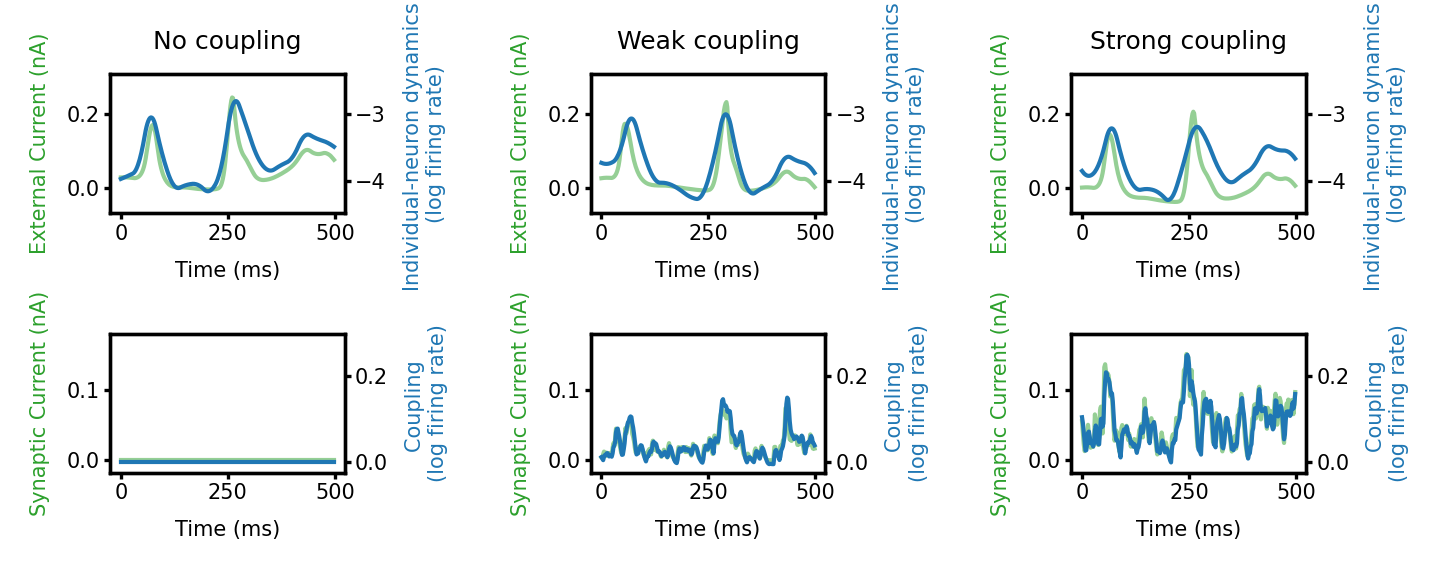

In [20]:
trial_to_plot = 4
utils.use_pdf_plot()
fig, axes = plt.subplots(2, 3, figsize=(5, 2), dpi=300)
title_list = ['No coupling', 'Weak coupling', 'Strong coupling']
log_fr_change = np.log(2)
xx = np.arange(0, 500, 2)
for col, conn in enumerate([0.0, 0.1, 0.2]):

    # Plot I_ext and firing rates stimulus
    ax = axes[0,col]
    I_ext = rcd_for_plot[conn]['I_ext'][::10,:,trial_to_plot][npadding:,:].mean(axis=1)
    firing_rates_stimulus = rcd_for_plot[conn]['firing_rates_stimulus'][:,:,trial_to_plot].mean(axis=1)
    
    # Plot I_ext
    ax.plot(xx, I_ext, 'tab:green', alpha=0.5, label='I_ext')
    ax.set_ylabel('External Current (nA)', color='tab:green')
    ax.set_xlabel('Time (ms)')
    # ax.legend(loc='upper left')
    ax.set_title(f'{title_list[col]}')
    ax.set_ylim(-0.07, 0.31)
    ax.set_xticks([0, 250, 500])
    
    # Plot firing rates with separate y-axis
    ax2 = ax.twinx()
    ax2.plot(xx, firing_rates_stimulus -log_fr_change, 'tab:blue', label='r')
    ax2.set_ylabel('Individual-neuron dynamics \n(log firing rate)', color='tab:blue')
    ax2.tick_params(axis='y')
    ax2.set_ylim(-3.8-log_fr_change, -1.7-log_fr_change)
    # ax2.legend(loc='upper right')
    
    # Plot I_syn and firing rates coupling  
    ax = axes[1,col]
    I_syn = rcd_for_plot[conn]['I_syn'][npadding:,:,trial_to_plot].mean(axis=1)
    firing_rates_coupling = rcd_for_plot[conn]['firing_rates_coupling'][:,:,trial_to_plot].mean(axis=1)
    
    # Plot I_syn
    ax.plot(xx, I_syn, 'tab:green', alpha=0.5, label='I_syn')
    ax.set_ylabel('Synaptic Current (nA)', color='tab:green')
    ax.set_xlabel('Time (ms)')
    ax.set_ylim(-0.018, 0.15+0.015*2)
    ax.set_xticks([0, 250, 500])
    # ax.legend(loc='upper left')
    
    # Plot coupling rates with separate y-axis
    ax2 = ax.twinx()
    ax2.plot(xx, firing_rates_coupling, 'tab:blue', label='r')
    ax2.set_ylabel('Coupling \n(log firing rate)', color='tab:blue')
    ax2.tick_params(axis='y')
    ax2.set_ylim(-0.025, 0.25+0.025*2)
    # ax2.legend(loc='upper right')


plt.tight_layout()
plt.savefig('Figure/Figure3_compare_current_and_fitted_components.pdf', bbox_inches='tight', dpi=300)

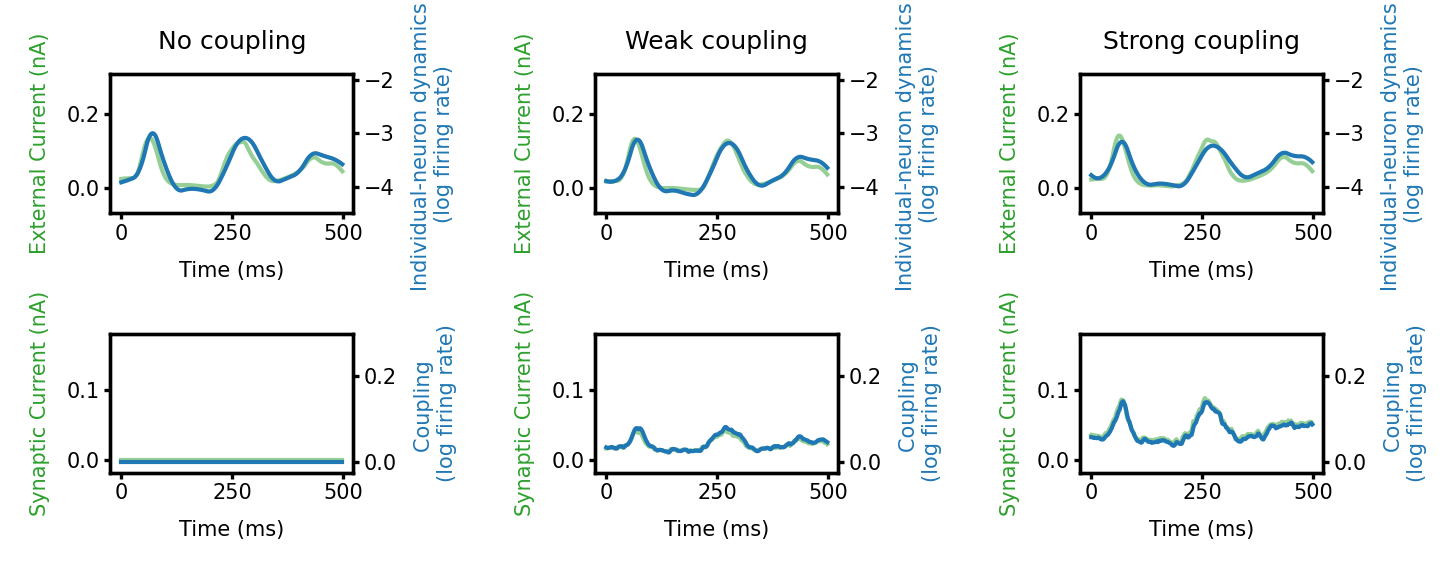

In [23]:
trial_to_plot = 4
utils.use_pdf_plot()
fig, axes = plt.subplots(2, 3, figsize=(5, 2), dpi=300)
title_list = ['No coupling', 'Weak coupling', 'Strong coupling']
log_fr_change = np.log(2)
xx = np.arange(0, 500, 2)
for col, conn in enumerate([0.0, 0.1, 0.2]):

    # Plot I_ext and firing rates stimulus
    ax = axes[0,col]
    I_ext = rcd_for_plot[conn]['I_ext'][::10,:,:][npadding:,:].mean(axis=(1,2))
    firing_rates_stimulus = rcd_for_plot[conn]['firing_rates_stimulus'][:,:,:].mean(axis=(1,2))
    
    # Plot I_ext
    ax.plot(xx, I_ext, 'tab:green', alpha=0.5, label='I_ext')
    ax.set_ylabel('External Current (nA)', color='tab:green')
    ax.set_xlabel('Time (ms)')
    # ax.legend(loc='upper left')
    ax.set_title(f'{title_list[col]}')
    ax.set_ylim(-0.07, 0.31)
    ax.set_xticks([0, 250, 500])
    
    # Plot firing rates with separate y-axis
    ax2 = ax.twinx()
    ax2.plot(xx, firing_rates_stimulus -log_fr_change, 'tab:blue', label='r')
    ax2.set_ylabel('Individual-neuron dynamics \n(log firing rate)', color='tab:blue')
    ax2.tick_params(axis='y')
    ax2.set_ylim(-3.8-log_fr_change, -1.2-log_fr_change)
    # ax2.legend(loc='upper right')
    
    # Plot I_syn and firing rates coupling  
    ax = axes[1,col]
    I_syn = rcd_for_plot[conn]['I_syn'][npadding:,:,:].mean(axis=(1,2))
    firing_rates_coupling = rcd_for_plot[conn]['firing_rates_coupling'][:,:,:].mean(axis=(1,2))
    
    # Plot I_syn
    ax.plot(xx, I_syn, 'tab:green', alpha=0.5, label='I_syn')
    ax.set_ylabel('Synaptic Current (nA)', color='tab:green')
    ax.set_xlabel('Time (ms)')
    ax.set_ylim(-0.018, 0.15+0.015*2)
    ax.set_xticks([0, 250, 500])
    # ax.legend(loc='upper left')
    
    # Plot coupling rates with separate y-axis
    ax2 = ax.twinx()
    ax2.plot(xx, firing_rates_coupling, 'tab:blue', label='r')
    ax2.set_ylabel('Coupling \n(log firing rate)', color='tab:blue')
    ax2.tick_params(axis='y')
    ax2.set_ylim(-0.025, 0.25+0.025*2)
    # ax2.legend(loc='upper right')


plt.tight_layout()
plt.savefig('Figure/SupFigure_EIF_varying_synaptic_strength_mean.pdf', bbox_inches='tight', dpi=300)